In [151]:
%pip install kydavra pandas numpy scikit-learn matplotlib seaborn optuna xgboost lightgbm shap tabulate plotly nbformat

Note: you may need to restart the kernel to use updated packages.


### Dataset Description

### Features

| Feature Name                  | Description                                                                                                   | Type      |
|-------------------------------|---------------------------------------------------------------------------------------------------------------|-----------|
| `destination`                 | Type of trip destination (e.g., Bar, Restaurant, CarryAway).                                                  | string    |
| `passanger`                   | Type of traveller (e.g., Alone, Friend(s), Partner, Kids).                                                    | string    |
| `weather`                     | Weather conditions at the time (e.g., Sunny, Rainy, Snowy).                                                   | string    |
| `temperature`                 | Temperature level category (e.g., 30, 50, 80).                                                                | integer   |
| `coupon`                      | Coupon category offered (e.g., CoffeeHouse, RestaurantLessThan20, CarryAway).                                 | string    |
| `expiration`                  | Coupon validity period (e.g., 2h, 1d).                                                                        | string    |
| `gender`                      | Gender of the person.                                                                                         | string    |
| `age`                         | Age of the person.                                                                                            | integer   |
| `maritalStatus`               | Marital status (e.g., Single, Married).                                                                       | string    |
| `has_children`                | Indicates if the person has children (0 = No, 1 = Yes).                                                       | integer   |
| `education`                   | Highest education level (e.g., Some High School, Bachelors, Graduate).                                       | string    |
| `occupation`                  | Type of job or profession.                                                                                    | string    |
| `income`                      | Income range category (e.g., Less than $12,500, $25,000–$50,000).                                             | string    |
| `car`                         | Indicates if the user owns a car.                                                                             | string    |
| `Bar`                         | Frequency of visiting bars (e.g., never, 1~3 times, 4~8 times, >8 times).                                    | string    |
| `CoffeeHouse`                 | Frequency of visiting coffee houses.                                                                         | string    |
| `CarryAway`                   | Frequency of using carry-away services.                                                                      | string    |
| `RestaurantLessThan20`        | Frequency of visiting restaurants with bills under $20.                                                      | string    |
| `Restaurant20To50`            | Frequency of visiting restaurants with bills between $20 and $50.                                            | string    |
| `toCoupon_GEQ5min`            | Whether the destination is at least 5 minutes away.                                                           | integer   |
| `toCoupon_GEQ15min`           | Whether the destination is at least 15 minutes away.                                                          | integer   |
| `toCoupon_GEQ25min`           | Whether the destination is at least 25 minutes away.                                                          | integer   |
| `direction_same`              | Whether the coupon location is in the same direction as the user’s travel route.                              | integer   |
| `direction_opp`               | Whether the coupon location is in the opposite direction from the user’s route.                               | integer   |

### Target

The target variable is `Y` (or sometimes named `accepted_coupon` ), it indicates whether the user accepted the coupon (`1 = yes`, `0 = no`).  
Thus, this is a Supervised Classification Machine Learning Problem.

### Problem Description

This dataset contains information about users, their demographics, travel context, and coupon characteristics. The goal is to predict whether a user will accept a given coupon based on contextual and personal factors such as age, income, weather, and distance to the location.  

It is designed for research and evaluation in behavioral prediction, recommendation systems, and context-aware marketing.

In [152]:
# Import Data Structures
import pandas as pd

# Import Data Manipulation Libraries
import numpy as np
from collections import defaultdict
from typing import List, Tuple, Dict, Any

# Import Base Classes for Type Annotation
from sklearn.base import BaseEstimator, TransformerMixin, clone
from numbers import Number

# Import Structure Manipulation Methods
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# Import Visualization Libs
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
sns.set_style(style="whitegrid")
sns.set_palette('bright')

# Import Hyperparameter Tuning
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner

# Import ML Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Import Interpretation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
shap.initjs()

### Dataset Loading


In [153]:
coupon_df: pd.DataFrame = pd.read_csv(
    filepath_or_buffer='data/coupon_recommendations.csv'
)
coupon_df.head()

destination  passanger weather  temperature                 coupon  \
0  No Urgent Place      Alone   Sunny           55        Restaurant(<20)   
1  No Urgent Place  Friend(s)   Sunny           80           Coffee House   
2  No Urgent Place  Friend(s)   Sunny           80  Carry out & Take away   
3  No Urgent Place  Friend(s)   Sunny           80           Coffee House   
4  No Urgent Place  Friend(s)   Sunny           80           Coffee House   

  expiration  gender age      maritalStatus  has_children  ... CoffeeHouse  \
0         1d  Female  21  Unmarried partner             1  ...       never   
1         2h  Female  21  Unmarried partner             1  ...       never   
2         2h  Female  21  Unmarried partner             1  ...       never   
3         2h  Female  21  Unmarried partner             1  ...       never   
4         1d  Female  21  Unmarried partner             1  ...       never   

  CarryAway RestaurantLessThan20 Restaurant20To50 toCoupon_GEQ5min  \
0       NaN                  4~8              1~3                1   
1       NaN                  4~8              1~3                1   
2       NaN                  4~8              1~3                1   
3       NaN                  4~8              1~3                1   
4       NaN                  4~8              1~3                1   

  toCoupon_GEQ15min toCoupon_GEQ25min direction_same direction_opp  \
0                 0                 0              0             1   
1                 0                 0              0             1   
2                 1                 0              0             1   
3                 1                 0              0             1   
4                 1                 0              0             1   

   Accept(Y/N?)  
0             1  
1             0  
2             1  
3             0  
4             0  

[5 rows x 25 columns]

### Data Analysis

In [154]:
coupon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   coupon                12684 non-null  object
 5   expiration            12684 non-null  object
 6   gender                12684 non-null  object
 7   age                   12684 non-null  object
 8   maritalStatus         12684 non-null  object
 9   has_children          12684 non-null  int64 
 10  education             12684 non-null  object
 11  occupation            12684 non-null  object
 12  income                12684 non-null  object
 13  car                   108 non-null    object
 14  Bar                   12577 non-null  object
 15  CoffeeHouse           12467 non-null

Having a glance at the dataset, I see that it is made of 24 features, and most of them are of type `object`. Specifically, 16 features are of `object` datatype (in other words, string), and 8 features are numerical (`int64`).  

Most categorical variables represent user or contextual characteristics — such as `destination`, `passanger`, `weather`, `coupon`, and `occupation` — which will require appropriate **encoding techniques** (like one-hot or ordinal encoding) to be transformed into numerical form for model training.  

Additionally, some features, such as `toCoupon_GEQ5min`, `toCoupon_GEQ15min`, and `direction_same`, are binary indicators, already in numeric form and suitable for direct use in modeling.  

No significant missing values are detected in most columns; however, being string-type, **empty strings** might exist and need to be handled as **null equivalents** before preprocessing.  

It is also worth noting that the `car` column contains only **108 non-null entries** across the entire dataset, making it **practically useless** for predictive modeling, as it lacks sufficient data coverage to provide meaningful insights or improve model performance. 


In [155]:
categorical_features: list[str] = []
numerical_features: list[str] = []

for col in coupon_df.columns:
    if coupon_df[col].dtype == 'object':
        print(f"Feature '{col}' has {len(coupon_df[col].unique())} Unique Values: {coupon_df[col].unique()}\n")
        categorical_features.append(col)
    else:
        numerical_features.append(col)

Feature 'destination' has 3 Unique Values: ['No Urgent Place' 'Home' 'Work']

Feature 'passanger' has 4 Unique Values: ['Alone' 'Friend(s)' 'Kid(s)' 'Partner']

Feature 'weather' has 3 Unique Values: ['Sunny' 'Rainy' 'Snowy']

Feature 'coupon' has 5 Unique Values: ['Restaurant(<20)' 'Coffee House' 'Carry out & Take away' 'Bar'
 'Restaurant(20-50)']

Feature 'expiration' has 2 Unique Values: ['1d' '2h']

Feature 'gender' has 2 Unique Values: ['Female' 'Male']

Feature 'age' has 8 Unique Values: ['21' '46' '26' '31' '41' '50plus' '36' 'below21']

Feature 'maritalStatus' has 5 Unique Values: ['Unmarried partner' 'Single' 'Married partner' 'Divorced' 'Widowed']

Feature 'education' has 6 Unique Values: ['Some college - no degree' 'Bachelors degree' 'Associates degree'
 'High School Graduate' 'Graduate degree (Masters or Doctorate)'
 'Some High School']

Feature 'occupation' has 25 Unique Values: ['Unemployed' 'Architecture & Engineering' 'Student'
 'Education&Training&Library' 'Healthcare 

Categorical Feature Summary

The dataset contains a variety of categorical features describing user context, demographics, and coupon details.  
Most features, such as `destination`, `passanger`, `weather`, and `coupon`, have a small number of unique values (2–9), while `occupation` shows the highest diversity with 25 unique categories.  

Several frequency-based features (`Bar`, `CoffeeHouse`, `CarryAway`, `RestaurantLessThan20`, `Restaurant20To50`) include missing values represented as `NaN`.  

The `car` column contains only 108 valid entries across the dataset, making it practically useless for modeling due to insufficient data coverage.  

The analysis confirms that `age` should be treated as an **ordinal variable** (grouped into ranges like $21-25$ or $31-40$) rather than a continuous numeric one.

Overall, the dataset is highly **categorical**, requiring appropriate **encoding** methods before training any predictive models.  


In [156]:
coupon_df[coupon_df.duplicated()]

destination  passanger weather  temperature        coupon  \
30     No Urgent Place  Friend(s)   Sunny           80  Coffee House   
96     No Urgent Place  Friend(s)   Sunny           80  Coffee House   
162    No Urgent Place  Friend(s)   Sunny           80  Coffee House   
184    No Urgent Place  Friend(s)   Sunny           80  Coffee House   
201    No Urgent Place  Friend(s)   Sunny           80  Coffee House   
...                ...        ...     ...          ...           ...   
10454  No Urgent Place     Kid(s)   Sunny           80  Coffee House   
10515  No Urgent Place     Kid(s)   Sunny           80  Coffee House   
10592  No Urgent Place     Kid(s)   Sunny           80  Coffee House   
10670  No Urgent Place     Kid(s)   Sunny           80  Coffee House   
10708  No Urgent Place     Kid(s)   Sunny           80  Coffee House   

      expiration  gender     age    maritalStatus  has_children  ...  \
30            2h    Male      21           Single             0  ...   
96            2h    Male      21           Single             0  ...   
162           2h    Male      26           Single             0  ...   
184           2h  Female      26           Single             1  ...   
201           2h    Male      21           Single             0  ...   
...          ...     ...     ...              ...           ...  ...   
10454         1d  Female      36         Divorced             1  ...   
10515         1d  Female  50plus  Married partner             1  ...   
10592         1d  Female      26  Married partner             1  ...   
10670         1d  Female      26  Married partner             1  ...   
10708         1d  Female      41           Single             1  ...   

      CoffeeHouse CarryAway RestaurantLessThan20 Restaurant20To50  \
30          less1       4~8                  4~8            less1   
96          less1       1~3                less1              1~3   
162           gt8       gt8                  gt8              gt8   
184           1~3       4~8                  1~3            less1   
201         never       gt8                  1~3            less1   
...           ...       ...                  ...              ...   
10454         gt8       4~8                  4~8            less1   
10515         4~8       1~3                  4~8              1~3   
10592       never     less1                less1            less1   
10670       never       1~3                less1            never   
10708       less1       1~3                  1~3            less1   

      toCoupon_GEQ5min toCoupon_GEQ15min toCoupon_GEQ25min direction_same  \
30                   1                 0                 0              0   
96                   1                 0                 0              0   
162                  1                 0                 0              0   
184                  1                 0                 0              0   
201                  1                 0                 0              0   
...                ...               ...               ...            ...   
10454                1                 0                 0              0   
10515                1                 0                 0              0   
10592                1                 0                 0              0   
10670                1                 0                 0              0   
10708                1                 0                 0              0   

      direction_opp  Accept(Y/N?)  
30                1             0  
96                1             1  
162               1             0  
184               1             1  
201               1             0  
...             ...           ...  
10454             1             1  
10515             1             1  
10592             1             0  
10670             1             0  
10708             1             0  

[291 rows x 25 columns]

Although they are not a structural problem (the 291 rows represent only about 2.2% of the 12684 records), it is essential to remove them before building any predictive model to prevent overfitting and ensure that we evaluate the model's performance based on unique observations.

In [157]:
coupon_df.isnull().sum()

destination                 0
passanger                   0
weather                     0
temperature                 0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Accept(Y/N?)                0
dtype: int64

Most columns in the dataset are complete, with only a few containing missing values.  
The `car` feature has almost all values missing and can be safely removed.  
Other columns such as `Bar`, `CoffeeHouse`, `CarryAway`, `RestaurantLessThan20`, and `Restaurant20To50` have small amounts of missing data that can be imputed or treated as a separate category.  
Overall, missing values are minimal and should not significantly affect the analysis.  

### Data Cleaning
In this part we drop collumn car, raname collumn accept and map the age as a range

In [158]:
coupon_df_cleaned = coupon_df.drop_duplicates(keep='first')

In [159]:
coupon_df.drop(columns=['car'], inplace=True)
coupon_df.rename(columns={'Accept(Y/N?)': 'accept_coupon'}, inplace=True)

In [160]:
age_map = {
    "below21": "Below 21",
    "21":      "21-25",
    "26":      "26-30",
    "31":      "31-35",
    "36":      "36-40",
    "41":      "41-45",
    "46":      "46-49",
    "50plus":  "50+",
}

coupon_df["age"] = (
    coupon_df["age"].astype("string").str.strip().replace(age_map)
)

In [161]:
freq_cols = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']

for col in freq_cols:
    mode_val = coupon_df[col].mode()[0]
    coupon_df[col] = coupon_df[col].fillna(mode_val)
    print(f"Filled NaN in {col} with '{mode_val}'")


Filled NaN in Bar with 'never'
Filled NaN in CoffeeHouse with 'less1'
Filled NaN in CarryAway with '1~3'
Filled NaN in RestaurantLessThan20 with '1~3'
Filled NaN in Restaurant20To50 with 'less1'


In [162]:
coupon_df.isnull().sum()

destination             0
passanger               0
weather                 0
temperature             0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ5min        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
direction_opp           0
accept_coupon           0
dtype: int64

### Exploratory Data Analysis
As an important step in Dataset analysis is EDA (Exploratory Data Analysis) that involves Data Visualization in order to find relationships between features, analyze distributions and other specifics that can be described better and concise using visualization techniques and plots.

because i want my plots to be sorted in ascending order. So I created manual orderings for non-numeric categories (income and age) so my plots display in logical ascending order rather than alphabetical order.

In [163]:
income_order = [
    'Less than $12500', '$12500 - $24999', '$25000 - $37499',
    '$37500 - $49999', '$50000 - $62499', '$62500 - $74999',
    '$75000 - $87499', '$87500 - $99999', '$100000 or More'
]
age_order = ['Below 21', '21-25', '26-30', '31-35', '36-40', '41-45', '46-49', '50+']


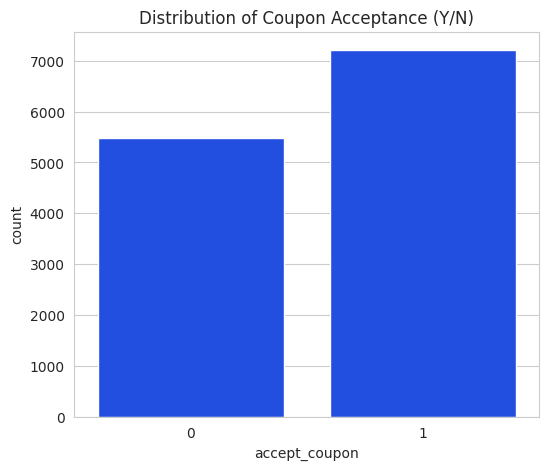

Target Variable Proportions:
 accept_coupon
1    56.843267
0    43.156733
Name: proportion, dtype: float64


In [164]:
plt.figure(figsize=(6, 5))
sns.countplot(x='accept_coupon', data=coupon_df)
plt.title('Distribution of Coupon Acceptance (Y/N)')
plt.show()

# Print proportions
target_proportions = coupon_df['accept_coupon'].value_counts(normalize=True) * 100
print("Target Variable Proportions:\n", target_proportions)

As it may be seen from the bar chart, the target variable accept_coupon exhibits a moderate class imbalance. The category labeled '1' (Yes, accepted the coupon) has a higher frequency, with approximately 7,200 instances, while the category '0' (No, did not accept the coupon) contains around 5,500 instances. 

Based on the calculated proportions, approximately 56.7% of users accepted the coupon, while 43.3% declined it. This indicates that while the dataset is not severely imbalanced, there is a noticeable tendency toward coupon acceptance in this population. Such a distribution should be taken into account during model training, particularly when evaluating performance metrics, to ensure the model does not become biased toward the majority class (acceptance). Techniques such as stratified sampling, resampling, or using appropriate evaluation metrics (e.g., F1-score, precision-recall AUC) may be necessary to address this imbalance effectively. 


Age distribution (%)
age
21-25       20.92
26-30       20.18
31-35       16.08
36-40        10.4
41-45        8.62
46-49        5.41
50+          14.1
Below 21     4.31


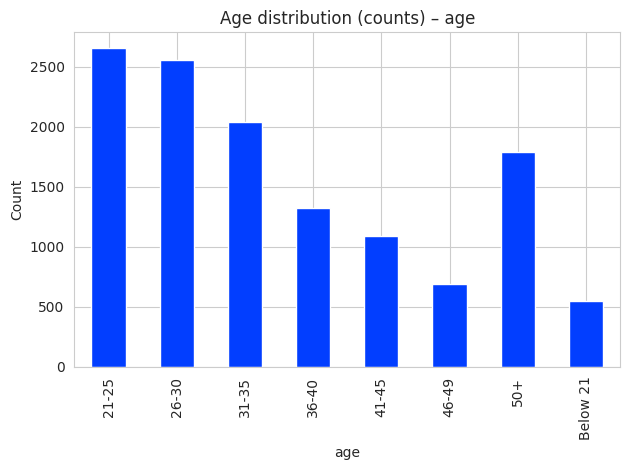

In [165]:
age_col = "age"

# counts plot
age_series = coupon_df[age_col].astype("string")
counts = age_series.value_counts(dropna=False).sort_index()
plt.figure()
cmap = plt.get_cmap('magma')
counts.plot(kind="bar")
plt.title(f"Age distribution (counts) – {age_col}")
plt.ylabel("Count")
plt.tight_layout()

# print percentages to console
perc = (counts / counts.sum() * 100)
print("\nAge distribution (%)")
print(perc.round(2).to_string())


The age distribution is heavily skewed toward younger users, with the 21-25 (20.9%) and 26-30 (20.2%) groups making up over 40% of the dataset. The 31-35 group follows at 16.1%, while older brackets decline steadily, except for 50+, which rebounds at 14.1%, suggesting a secondary user segment. The youngest group (Below 21) is smallest at just 4.3%, reflecting either lower participation or data collection limitations for this demographic.

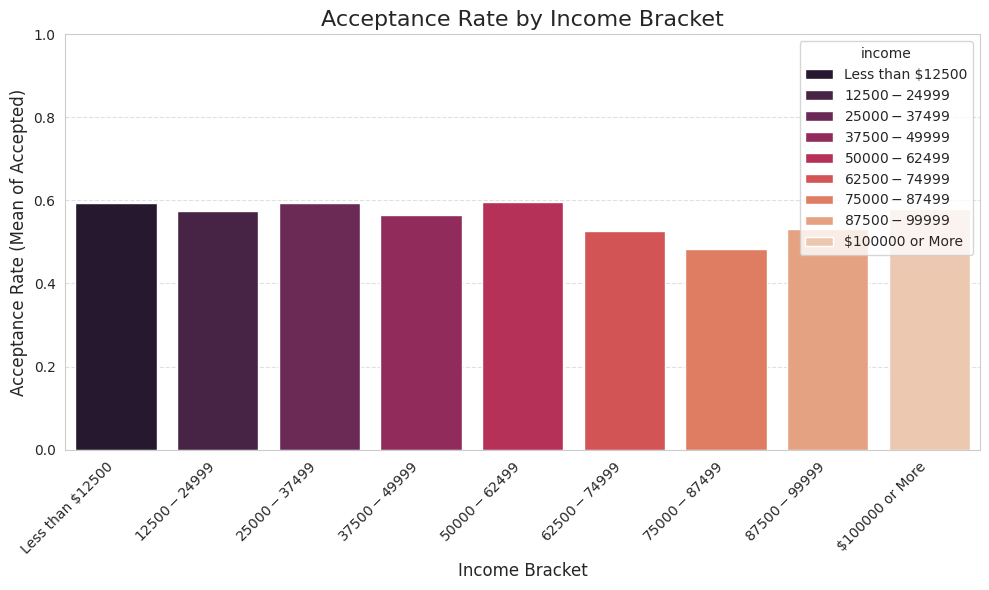

In [166]:
acc = coupon_df['accept_coupon']

income_acceptance_rate = (
    pd.DataFrame({'income': coupon_df['income'], 'acc': acc})
      .groupby('income', dropna=False)['acc']
      .mean()
      .reindex(income_order)
      .reset_index(name='accept_rate')
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=income_acceptance_rate,
    x='income', y='accept_rate',
    hue='income', 
    dodge=False,
    palette='rocket',
    legend=True 
)
plt.title('Acceptance Rate by Income Bracket', fontsize=16)
plt.xlabel('Income Bracket', fontsize=12)
plt.ylabel('Acceptance Rate (Mean of Accepted)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

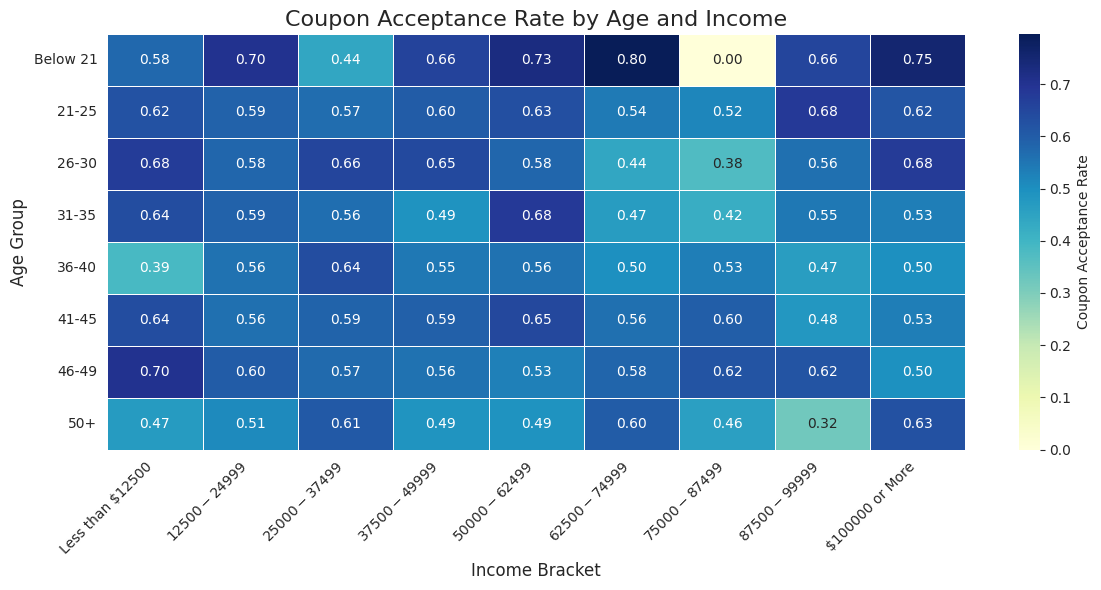

In [167]:
df_plot = coupon_df[['age', 'income']].copy()
df_plot['accept'] = acc

age_order = ['Below 21', '21-25', '26-30', '31-35', '36-40', '41-45', '46-49', '50+']
income_order = [
    'Less than $12500', '$12500 - $24999', '$25000 - $37499',
    '$37500 - $49999', '$50000 - $62499', '$62500 - $74999',
    '$75000 - $87499', '$87500 - $99999', '$100000 or More'
]

acceptance_rates = df_plot.groupby(['age', 'income'])['accept'].mean().unstack(fill_value=0)

# Reindex to ensure correct order
acceptance_rates = acceptance_rates.reindex(index=age_order, columns=income_order)

plt.figure(figsize=(12, 6))
sns.heatmap(
    acceptance_rates,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Coupon Acceptance Rate'},
    linewidths=0.5
)
plt.title('Coupon Acceptance Rate by Age and Income', fontsize=16)
plt.xlabel('Income Bracket', fontsize=12)
plt.ylabel('Age Group', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The heatmap reveals nuanced interactions between age and income in coupon acceptance. The highest acceptance rates (up to 0.80) occur among younger users (Below 21, 21-25) with mid-to-high incomes ($50K-$75K) suggesting younger, financially stable users are most responsive. 

Notably, users aged 36-40 show the lowest overall acceptance, especially in mid-income brackets (e.g., 0.39 for <$12.5K). In contrast, older users (50+) with very high income ($100K+) rebound strongly (0.63), while those in the $87.5K–$99.9K range dip sharply (0.32), hinting at possible targeting inefficiencies or behavioral shifts. 

Overall, younger + higher-income and older + top-tier income groups are prime targets, while middle-aged, mid-income users appear least receptive. Segment-specific strategies may be needed to improve engagement across all demographics. 

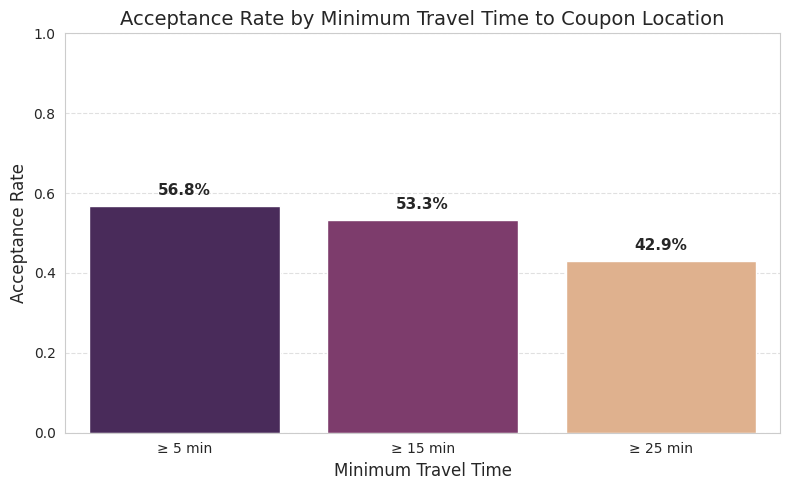

In [168]:
cols = ['toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min']
labels = ['≥ 5 min', '≥ 15 min', '≥ 25 min']

rates = [
    coupon_df[coupon_df[col] == 1]['accept_coupon'].mean()
    for col in cols
]

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=labels, y=rates, palette='flare',hue=rates, legend=False)

for i, rate in enumerate(rates):
    ax.text(i, rate + 0.02, f"{rate*100:.1f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title('Acceptance Rate by Minimum Travel Time to Coupon Location', fontsize=14)
plt.xlabel('Minimum Travel Time', fontsize=12)
plt.ylabel('Acceptance Rate', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Acceptance rates decline as required travel time increases:   
- ≥ 5 min: ~56.8% 
- ≥ 15 min: ~53.3%  
- ≥ 25 min: ~42.9%

This suggests users are significantly less likely to accept coupons that require longer travel. The ~14 percentage-point drop from 5 to 25+ minutes highlights travel time as a key barrier, likely reflecting convenience, time sensitivity, or perceived effort. For maximum uptake, coupons should be offered for nearby or easily accessible locations. 

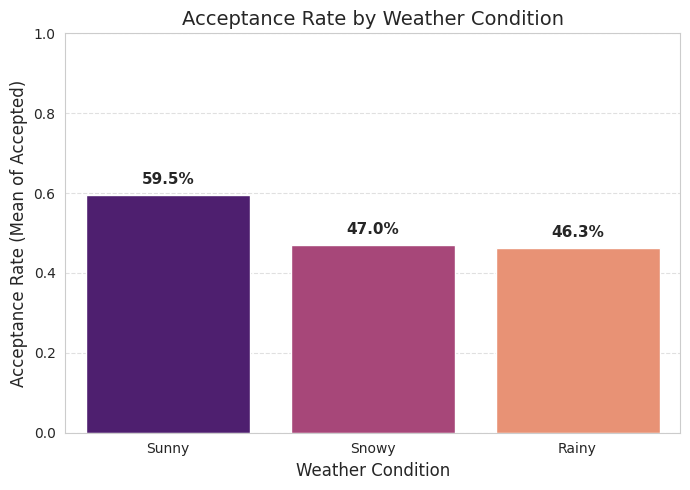

In [169]:
weather_acceptance_rate = coupon_df.groupby('weather')['accept_coupon'].mean().sort_values(ascending=False)

weather_df = weather_acceptance_rate.reset_index(name='Acceptance_Rate')

plt.figure(figsize=(7, 5))
sns.barplot(
    data = weather_df,
    x = 'weather',
    y = 'Acceptance_Rate',
    palette = 'magma',
    hue ='weather',
)
plt.title('Acceptance Rate by Weather Condition', fontsize=14)
plt.xlabel('Weather Condition', fontsize=12)
plt.ylabel('Acceptance Rate (Mean of Accepted)', fontsize=12)
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)

for i, rate in enumerate(weather_df['Acceptance_Rate']):
    plt.text(i, rate + 0.02, f"{rate*100:.1f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

Users are ~13-14 percentage points more likely to accept coupons on sunny days vs snowy or rainy ones. This suggests weather impacts willingness to travel or engage, making sunny conditions ideal for coupon campaigns. Rain and snow appear similarly discouraging, likely due to reduced mobility or outdoor activity. 

Takeaway: Time promotions with good weather for maximum uptake. 

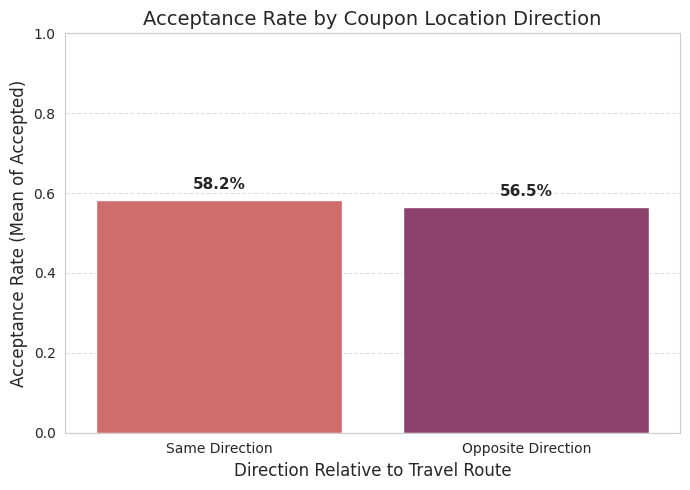

In [170]:
direction_same_rate = coupon_df[coupon_df['direction_same'] == 1]['accept_coupon'].mean()
direction_opp_rate = coupon_df[coupon_df['direction_opp'] == 1]['accept_coupon'].mean()

direction_data = pd.DataFrame({
    'Direction': ['Same Direction', 'Opposite Direction'],
    'Acceptance_Rate': [direction_same_rate, direction_opp_rate]
})

plt.figure(figsize=(7, 5))
sns.barplot(
    x='Direction',
    y='Acceptance_Rate',
    data=direction_data,
    hue='Direction',
    dodge=False,
    palette='flare',
)
plt.title('Acceptance Rate by Coupon Location Direction', fontsize=14)
plt.xlabel('Direction Relative to Travel Route', fontsize=12)
plt.ylabel('Acceptance Rate (Mean of Accepted)', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)

for i, rate in enumerate(direction_data['Acceptance_Rate']):
    plt.text(i, rate + 0.02, f"{rate*100:.1f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

Users are slightly more likely to accept coupons when the location is in the same direction as their travel route (58.2%) vs. opposite direction (56.5%). 

The difference is small (~1.7 percentage points), suggesting that while convenience matters, it’s not a major barrier, users still accept coupons even if they require a detour. 

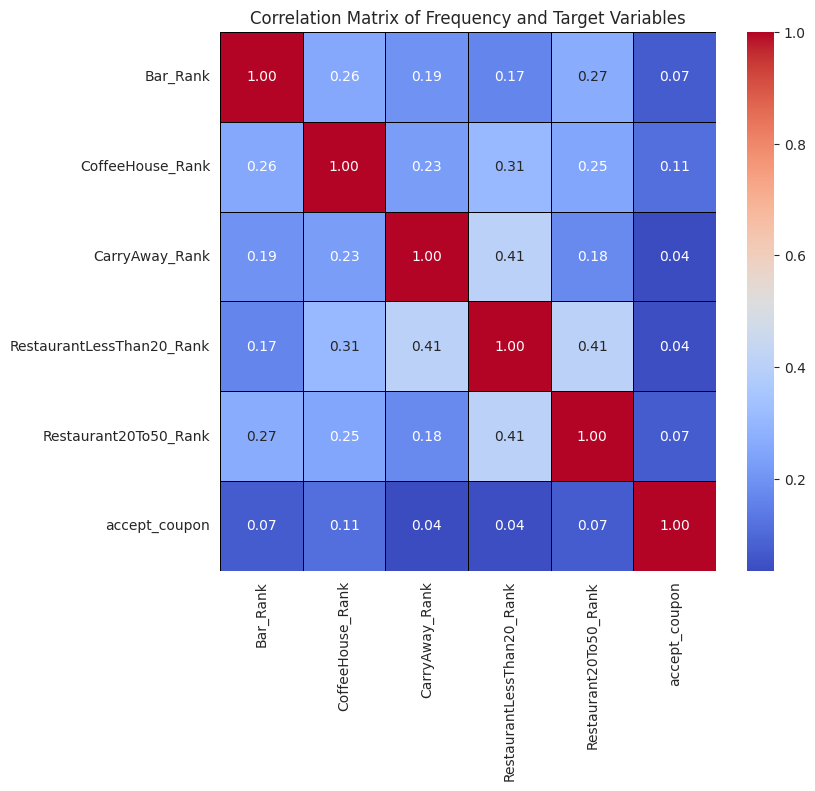

In [171]:
frequency_mapping = {
    'never': 0, 'less1': 1, '1~3': 2, '4~8': 3, 'gt8': 4
}
# Make a copy for correlation analysis
df_corr = coupon_df.copy() 

frequency_cols = [
    'Bar', 'CoffeeHouse', 'CarryAway', 
    'RestaurantLessThan20', 'Restaurant20To50'
]

for col in frequency_cols:
    df_corr[col + '_Rank'] = df_corr[col].map(frequency_mapping)

correlation_features = [col + '_Rank' for col in frequency_cols] + ['accept_coupon']
correlation_matrix = df_corr[correlation_features].corr()

plt.figure(figsize=(8, 7))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=.5, 
    linecolor='black'
)
plt.title('Correlation Matrix of Frequency and Target Variables')
plt.show()

All venue frequency features show very weak positive correlation with coupon acceptance, none exceed 0.11. 

This suggests that how often a user visits bars, coffee houses, or restaurants has little predictive power for whether they’ll accept a coupon. Even strong correlations between venues (e.g., CoffeeHouse and RestaurantLessThan20 = 0.31) don’t translate to influence on acceptance. 

In [172]:
for col in frequency_cols:
    df_corr[col + '_Rank'] = df_corr[col].map(frequency_mapping)

# Combine: simple average of all venue frequencies
df_corr['Avg_Frequency'] = df_corr[[col + '_Rank' for col in frequency_cols]].mean(axis=1)

# Optional: check correlation of combined feature with target
print("Correlation of Avg_Frequency with accept_coupon:",
      df_corr['Avg_Frequency'].corr(df_corr['accept_coupon']).round(3))

Correlation of Avg_Frequency with accept_coupon: 0.108


even the combined Avg_Frequency only has a weak correlation (0.108) with coupon acceptance, confirming your earlier heatmap insight

In [173]:
def add_data_labels(ax):
    """Adds the label (the 'Yes' acceptance percentage) to the top section of each bar."""
    for rect in ax.patches:
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        if y > 0 and height > 0:
            percentage = f'{height:.1f}%'
            ax.text(x + width / 2, y + height / 2, percentage, ha='center', va='center', color='black', fontweight='bold', fontsize=10)

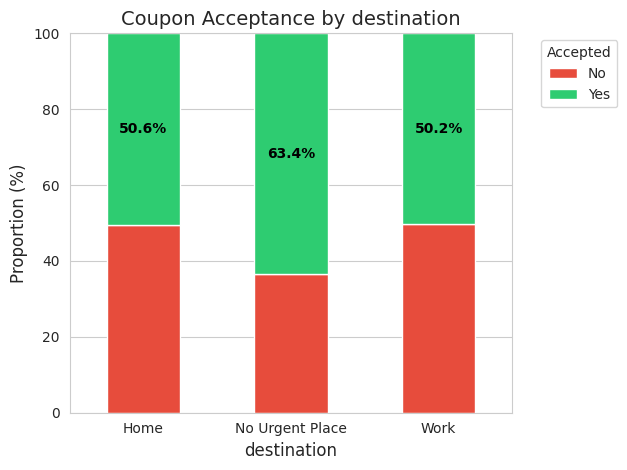

In [174]:
feature = 'destination'
cross_tab = pd.crosstab(coupon_df[feature], coupon_df['accept_coupon'], normalize='index') * 100

ax = cross_tab.plot(kind='bar', stacked=True, color=['#e74c3c', '#2ecc71'])
ax.set_ylim(0, 100)
add_data_labels(ax)
plt.title(f'Coupon Acceptance by {feature}', fontsize=14)
plt.xlabel(feature, fontsize=12)
plt.ylabel('Proportion (%)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Accepted', labels=['No', 'Yes'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

- “No Urgent Place” has the highest acceptance rate (63.4%) → users are more open to coupons when not rushing.
- “Home” and “Work” are neutral (~50%) → likely routine-driven, less flexible

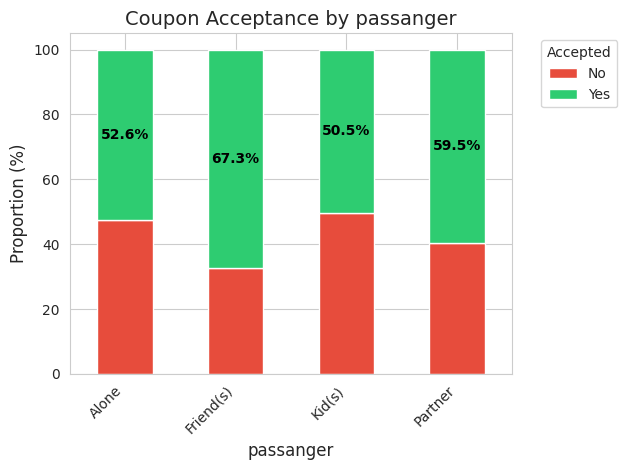

In [175]:
feature = 'passanger'
cross_tab = pd.crosstab(coupon_df[feature], coupon_df['accept_coupon'], normalize='index') * 100

ax = cross_tab.plot(kind='bar', stacked=True, color=['#e74c3c', '#2ecc71'])
add_data_labels(ax)
plt.title(f'Coupon Acceptance by {feature}', fontsize=14)
plt.xlabel(feature, fontsize=12)
plt.ylabel('Proportion (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Accepted', labels=['No', 'Yes'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Key takeaway: Users traveling with friends or partners are significantly more likely to accept coupons, likely due to social decision-making, shared cost, or spontaneous plans.

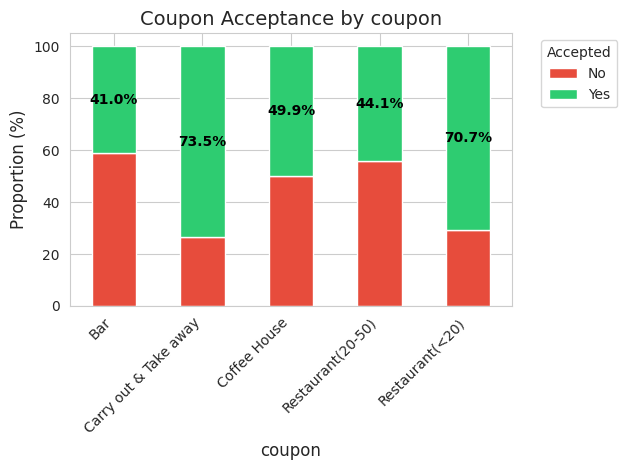

In [176]:
feature = 'coupon'
cross_tab = pd.crosstab(coupon_df[feature], coupon_df['accept_coupon'], normalize='index') * 100

ax = cross_tab.plot(kind='bar', stacked=True, color=['#e74c3c', '#2ecc71'])
add_data_labels(ax)
plt.title(f'Coupon Acceptance by {feature}', fontsize=14)
plt.xlabel(feature, fontsize=12)
plt.ylabel('Proportion (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Accepted', labels=['No', 'Yes'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Key Takeaway: Coupons for Carry out & Take away (73.5%) and Restaurant(<20) (70.7%) are overwhelmingly accepted. Coupons for Bars (41.0%) and Coffee Houses (49.9%) have the lowest acceptance rates, suggesting customers value convenience and cheaper meal options more than leisure/social-venue discounts.

<Figure size 600x500 with 0 Axes>

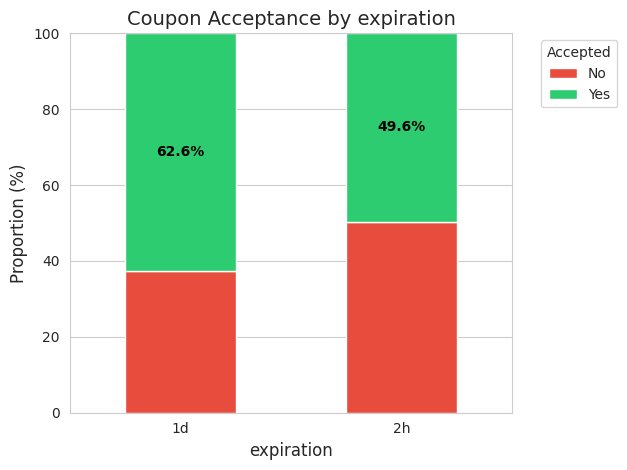

In [177]:
# 5. Plot pentru EXPIRATION
feature = 'expiration'
cross_tab = pd.crosstab(coupon_df[feature], coupon_df['accept_coupon'], normalize='index') * 100

plt.figure(figsize=(6, 5))
ax = cross_tab.plot(kind='bar', stacked=True, color=['#e74c3c', '#2ecc71'])
ax.set_ylim(0, 100)
add_data_labels(ax) # Adaugă etichetele
plt.title(f'Coupon Acceptance by {feature}', fontsize=14)
plt.xlabel(feature, fontsize=12)
plt.ylabel('Proportion (%)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Accepted', labels=['No', 'Yes'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

As axpected the longer the expiration time, the higher the chance to be accepted

<Figure size 600x500 with 0 Axes>

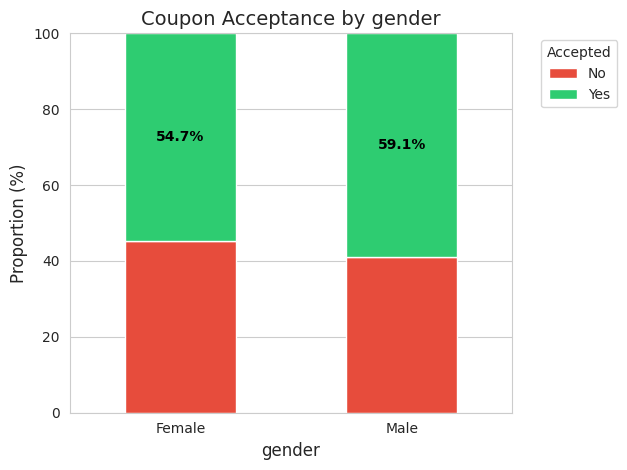

In [178]:
feature = 'gender'
cross_tab = pd.crosstab(coupon_df[feature], coupon_df['accept_coupon'], normalize='index') * 100

plt.figure(figsize=(6, 5))
ax = cross_tab.plot(kind='bar', stacked=True, color=['#e74c3c', '#2ecc71'])
ax.set_ylim(0, 100)
add_data_labels(ax)
plt.title(f'Coupon Acceptance by {feature}', fontsize=14)
plt.xlabel(feature, fontsize=12)
plt.ylabel('Proportion (%)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Accepted', labels=['No', 'Yes'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

not a lot of difference, just 5% more on the males. This suggests that gender, on its own, is a weak predictor of coupon acceptance.

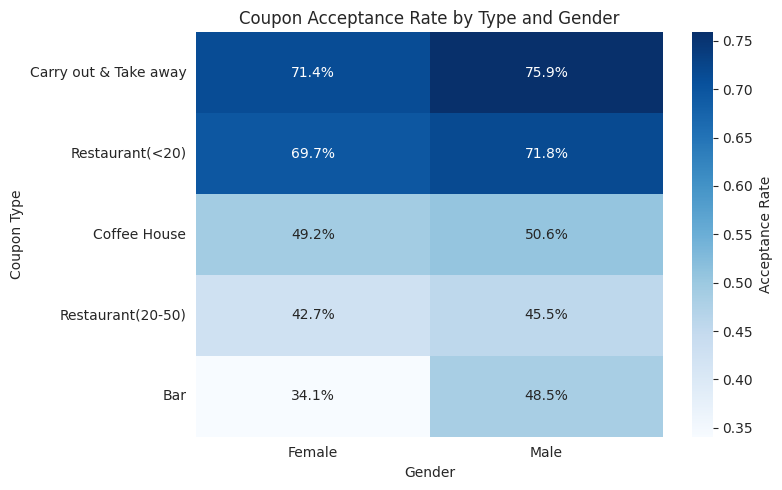

In [179]:
# Compute acceptance rate per (coupon, gender) group
heatmap_data = coupon_df.groupby(['coupon', 'gender'])['accept_coupon'].mean().unstack()

# Optional: reorder coupon types by overall popularity or acceptance
coupon_order = ['Carry out & Take away', 'Restaurant(<20)', 'Coffee House', 
                'Restaurant(20-50)', 'Bar']  # adjust names to match your data
if all(c in heatmap_data.index for c in coupon_order):
    heatmap_data = heatmap_data.reindex(coupon_order)

plt.figure(figsize=(8, 5))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1%",
    cmap='Blues',
    cbar_kws={'label': 'Acceptance Rate'}
)
plt.title('Coupon Acceptance Rate by Type and Gender')
plt.xlabel('Gender')
plt.ylabel('Coupon Type')
plt.tight_layout()
plt.show()

Key Takeaway: While Males consistently show a higher acceptance rate across all five coupon types, the most significant predictive factor remains the Coupon Type.

- Most Accepted: Carry out & Take away (71.4% for Females, 75.9% for Males) and Restaurant(<20) (69.7% for Females, 71.8% for Males) remain the most popular for both genders.

- Least Accepted: Bar coupons have the lowest acceptance rate overall, but the difference between genders is most pronounced here: Males (48.5%) accept Bar coupons at a significantly higher rate than Females (34.1%), highlighting a strong gender-coupon type interaction for this category.

- Weakest Predictors: Coupons for Coffee House and Restaurant(20-50) show the smallest difference in acceptance between the genders.

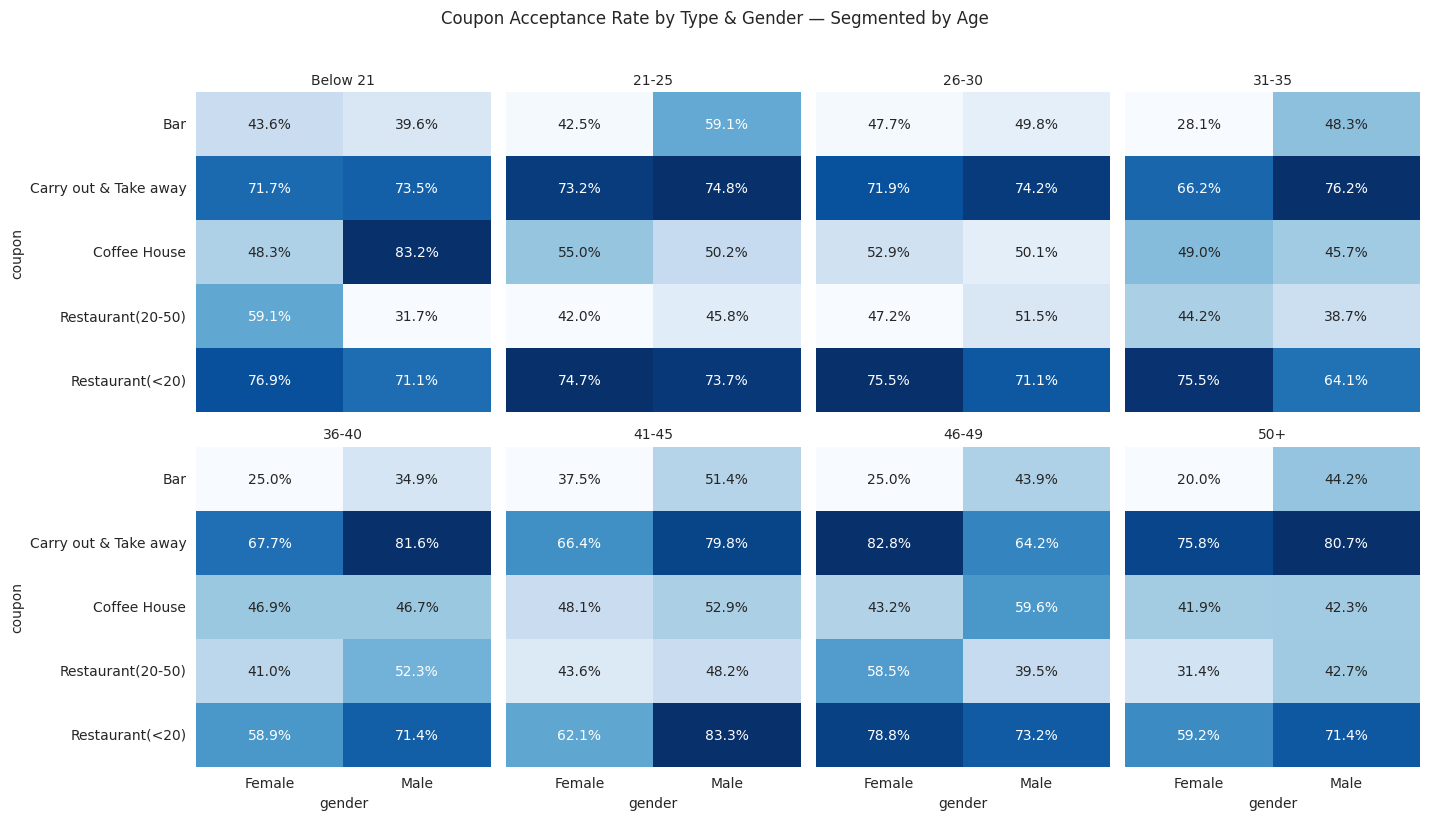

In [180]:
# Make sure 'age' is categorical with order
age_order = ['Below 21', '21-25', '26-30', '31-35', '36-40', '41-45', '46-49', '50+']
coupon_df['age'] = pd.Categorical(coupon_df['age'], categories=age_order, ordered=True)

# Create facets: one heatmap per age group
g = sns.FacetGrid(coupon_df, col='age', col_wrap=4, height=4, aspect=0.9)
g.map_dataframe(
    lambda data, **kws: sns.heatmap(
        data.groupby(['coupon', 'gender'])['accept_coupon'].mean().unstack(),
        annot=True, fmt=".1%", cmap='Blues', cbar=False, **kws
    )
)
g.set_titles(col_template='{col_name}')
g.fig.suptitle('Coupon Acceptance Rate by Type & Gender — Segmented by Age', y=1.02)
plt.tight_layout()
plt.show()

Young adults (21-25) are most responsive overall
- Especially males: 74.8% for CarryOut, 73.7% for Restaurant(<20), 59.1% for Bar. 

Gender gaps vary by age & coupon type   
    In Bar: Males accept more than females in all age groups, strongest gap in 26-30 (49.8% vs 47.7%) and 50+ (44.2% vs 20.0%).
    In Coffee House: Females often lead in younger groups (e.g., Below 21: 48.3% vs 83.2%)
        

Older users (50+) show strong gender polarization
- Males dominate in CarryOut (80.7%), Restaurant(<20) (71.4%), and Bar (44.2%).
- Females drop sharply, especially in Bar (20.0%) and CoffeeHouse (42.3%). 

Restaurant(<20) is universally popular
- Highest acceptance across almost all segments, especially among young and middle-aged users. 

CarryOut & Takeaway peaks in 46-49 group
- 82.8% (F) / 64.2% (M) - suggests mid-life users value convenience. 
     

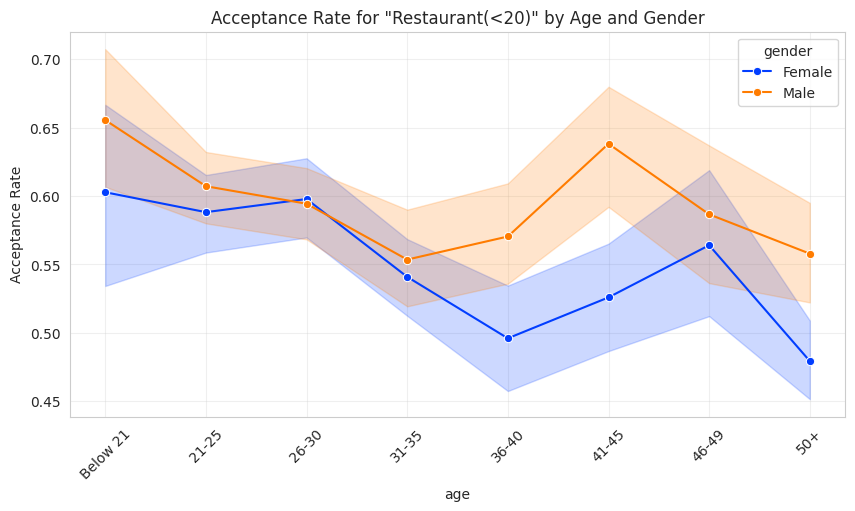

In [181]:
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=coupon_df,
    x='age',
    y='accept_coupon',
    hue='gender',
    estimator='mean',
    marker='o'
)
plt.title('Acceptance Rate for "Restaurant(<20)" by Age and Gender')
plt.ylabel('Acceptance Rate')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

Key Insights: 

- Overall high acceptance: Rates hover between 50-70%, confirms this is a popular coupon type.
- Peak at 41-45 for males (64%), then declines slightly.
- Females show more stability, steady around 55-60%, with a dip at 36-40 (≈50%) and recovery at 46-49.
- Youngest group (Below 21): Males accept more (65%) than females (60%).
- Oldest group (50+): Both genders drop, but males still outperform females (56% vs 48%).
    

This suggests mid-life males are the sweet spot for cheap restaurant coupons, possibly due to budget awareness or social habits. 
     

### Outlier detection

In [182]:
categorical_features: list[str] = []
numerical_features: list[str] = []

for col in coupon_df.columns:
    if coupon_df[col].dtype == 'object':
        print(f"Feature '{col}' has {len(coupon_df[col].unique())} Unique Values: {coupon_df[col].unique()}\n")
        categorical_features.append(col)
    else:
        print(f"Feature '{col}' has {len(coupon_df[col].unique())} Unique Values: {coupon_df[col].unique()}\n")
        numerical_features.append(col)

Feature 'destination' has 3 Unique Values: ['No Urgent Place' 'Home' 'Work']

Feature 'passanger' has 4 Unique Values: ['Alone' 'Friend(s)' 'Kid(s)' 'Partner']

Feature 'weather' has 3 Unique Values: ['Sunny' 'Rainy' 'Snowy']

Feature 'temperature' has 3 Unique Values: [55 80 30]

Feature 'coupon' has 5 Unique Values: ['Restaurant(<20)' 'Coffee House' 'Carry out & Take away' 'Bar'
 'Restaurant(20-50)']

Feature 'expiration' has 2 Unique Values: ['1d' '2h']

Feature 'gender' has 2 Unique Values: ['Female' 'Male']

Feature 'age' has 8 Unique Values: ['21-25', '46-49', '26-30', '31-35', '41-45', '50+', '36-40', 'Below 21']
Categories (8, object): ['Below 21' < '21-25' < '26-30' < '31-35' < '36-40' < '41-45' < '46-49' < '50+']

Feature 'maritalStatus' has 5 Unique Values: ['Unmarried partner' 'Single' 'Married partner' 'Divorced' 'Widowed']

Feature 'has_children' has 2 Unique Values: [1 0]

Feature 'education' has 6 Unique Values: ['Some college - no degree' 'Bachelors degree' 'Associates

At first glance, data is all categorial and we dont have outliers. But cannot definitively say there are no outliers. but the feature `toCoupon_GEQ5min` is constant in training needs to be removed


In [183]:
coupon_df = coupon_df.drop(columns=['toCoupon_GEQ5min'])

In [184]:
import pandas as pd
import numpy as np

# --- 1. Load the data ---
# Make sure your file is in the same directory as your notebook.
df = pd.read_csv("data/coupon_recommendations.csv")

# --- 2. Remove the 'car' column (as per previous steps) ---
if 'car' in df.columns:
    df = df.drop(columns=['car'])

# --- 3. Function to Group Rare Categories (The Outlier Handling Method) ---
def group_rare_categories(df, threshold=0.05):
    """
    Groups categories in 'object' dtype columns that are below a certain
    frequency threshold into a single 'Other' category.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - threshold (float): The maximum proportion a category can have to be considered 'rare'.

    Returns:
    - pd.DataFrame: The DataFrame with rare categories grouped.
    """
    df_cleaned = df.copy()
    # Select only the categorical columns (object dtype)
    object_cols = df_cleaned.select_dtypes(include=['object']).columns

    print(f"Applying rare category grouping with a threshold of {threshold*100}%.")
    
    for col in object_cols:
        # Calculate the frequency of each category
        # normalize=True gives proportions
        value_counts = df_cleaned[col].value_counts(normalize=True, dropna=False)
        
        # Identify categories whose frequency is below the threshold
        rare_categories = value_counts[value_counts < threshold].index.tolist()

        if rare_categories:
            # Replace rare categories with 'Other'
            df_cleaned[col] = df_cleaned[col].replace(rare_categories, 'Other')
            print(f"- {col}: Grouped {len(rare_categories)} rare categories into 'Other'.")
        
    return df_cleaned

# --- 4. Execute the Grouping ---
df_processed = group_rare_categories(df, threshold=0.05)

# --- 5. Verification (Optional but Recommended) ---
print("\n--- Verification of Changes ---")

# Check a column like 'maritalStatus' where 'Widowed' and 'Divorced' were rare
print("\nProcessed 'maritalStatus' counts:")
print(df_processed['maritalStatus'].value_counts(normalize=True))

# Check 'occupation' where many rare categories were grouped
print("\nProcessed 'occupation' counts (Top 5):")
print(df_processed['occupation'].value_counts(normalize=True).head())

del df_processed, df   # remove references
import gc; gc.collect()  # ask Python to reclaim memory
# Now 'df_processed' is ready for your modeling steps (e.g., one-hot encoding).

Applying rare category grouping with a threshold of 5.0%.
- age: Grouped 1 rare categories into 'Other'.
- maritalStatus: Grouped 2 rare categories into 'Other'.
- education: Grouped 1 rare categories into 'Other'.
- occupation: Grouped 18 rare categories into 'Other'.
- Bar: Grouped 2 rare categories into 'Other'.
- CoffeeHouse: Grouped 1 rare categories into 'Other'.
- CarryAway: Grouped 2 rare categories into 'Other'.
- RestaurantLessThan20: Grouped 2 rare categories into 'Other'.
- Restaurant20To50: Grouped 2 rare categories into 'Other'.

--- Verification of Changes ---

Processed 'maritalStatus' counts:
maritalStatus
Married partner      0.402081
Single               0.374645
Unmarried partner    0.172343
Other                0.050930
Name: proportion, dtype: float64

Processed 'occupation' counts (Top 5):
occupation
Other                      0.339719
Unemployed                 0.147430
Student                    0.124882
Computer & Mathematical    0.111006
Sales & Related      

80748

the thresolds is to big lets lower it to 1% because we lose data. especially in occupation. Grouping them loses valuable patterns about user behavior

In [185]:
print("=== Checking for Rare Categories ===\n")

for col in coupon_df.columns:
    if col == 'accept_coupon':
        continue
    
    value_counts = coupon_df[col].value_counts()
    percentages = (value_counts / len(coupon_df) * 100).round(2)

    rare_categories = percentages[percentages < 1.0]
    
    if len(rare_categories) > 0:
        print(f"Feature '{col}' has rare categories (<1% of data):")
        print(rare_categories)
        print()

=== Checking for Rare Categories ===

Feature 'education' has rare categories (<1% of data):
education
Some High School    0.69
Name: count, dtype: float64

Feature 'occupation' has rare categories (<1% of data):
occupation
Production Occupations                       0.87
Building & Grounds Cleaning & Maintenance    0.35
Farming Fishing & Forestry                   0.34
Name: count, dtype: float64



In [186]:
rare_categories = {
    'occupation': [
        'Production Occupations',
        'Building & Grounds Cleaning & Maintenance',
        'Farming Fishing & Forestry'
    ]
}

# Group them
for column, rare_values in rare_categories.items():
    n_affected = coupon_df[column].isin(rare_values).sum()
    coupon_df[column] = coupon_df[column].replace(rare_values, f'Other_{column.capitalize()}')
    print(f"{column}: Grouped {len(rare_values)} rare categories affecting {n_affected} rows")


occupation: Grouped 3 rare categories affecting 197 rows


### Data Transformation
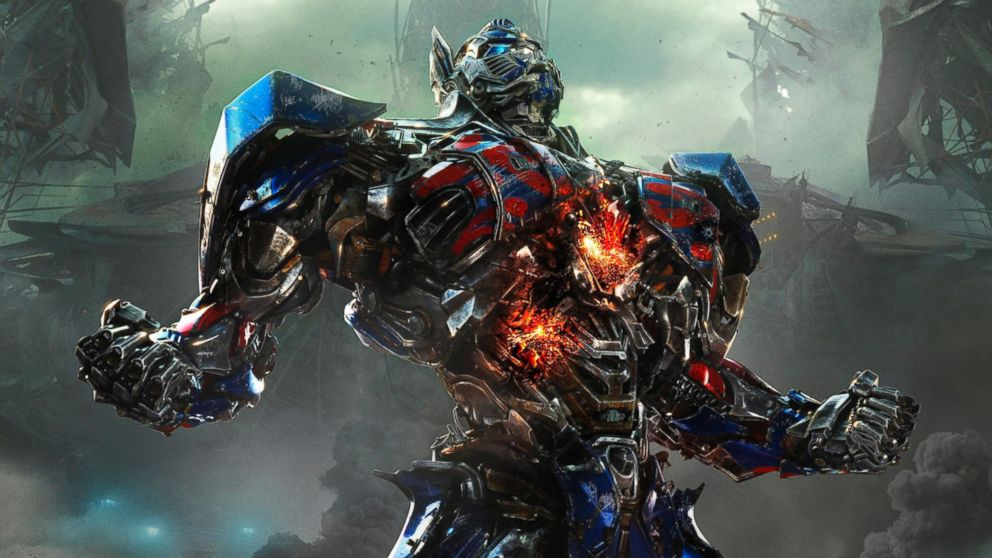

In [187]:
# class DataCleaner(BaseEstimator, TransformerMixin):
#     """Data cleaner that drops duplicates and tracks indices"""
    
#     def __init__(self):
#         self.modes_ = {}
#         self.rare_categories_ = {
#             'occupation': [
#                 'Production Occupations',
#                 'Building & Grounds Cleaning & Maintenance',
#                 'Farming Fishing & Forestry'
#             ]
#         }
#         self.retained_indices_ = None
    
#     def fit(self, X, y=None):
#         freq_cols = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
#         for col in freq_cols:
#             if col in X.columns:
#                 self.modes_[col] = X[col].mode()[0] if not X[col].mode().empty else 'never'
#         return self
    
#     def transform(self, X):
#         X_clean = X.copy()

#         # Other operations
#         X_clean = X_clean.drop(columns=['car', 'toCoupon_GEQ5min'], errors='ignore')
        
#         if 'Accept(Y/N?)' in X_clean.columns:
#             X_clean = X_clean.rename(columns={'Accept(Y/N?)': 'accept_coupon'})
        
#         for col, mode_val in self.modes_.items():
#             if col in X_clean.columns:
#                 X_clean[col] = X_clean[col].fillna(mode_val)
        
#         for column, rare_values in self.rare_categories_.items():
#             if column in X_clean.columns:
#                 X_clean[column] = X_clean[column].replace(rare_values, f'Other_{column.capitalize()}')
        
#         return X_clean

# # Then use this in your pipeline and manually align y during evaluation

In [188]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Feature engineering steps"""
    def __init__(self):
        self.freq_mapping = {'never': 0, 'less1': 1, '1~3': 2, '4~8': 3, 'gt8': 4}
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_eng = X.copy()
        
        # Create frequency scores
        for col in ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']:
            if col in X_eng.columns:
                X_eng[f'{col}_score'] = X_eng[col].map(self.freq_mapping)
        
        # Create aggregated scores
        if all(col in X_eng.columns for col in ['RestaurantLessThan20_score', 'Restaurant20To50_score']):
            X_eng['total_dining_score'] = X_eng['RestaurantLessThan20_score'] + X_eng['Restaurant20To50_score']
        
        if all(col in X_eng.columns for col in ['Bar_score', 'CoffeeHouse_score']):
            X_eng['total_social_score'] = X_eng['Bar_score'] + X_eng['CoffeeHouse_score']
        
        if all(col in X_eng.columns for col in ['Bar_score', 'CoffeeHouse_score', 'CarryAway_score', 'RestaurantLessThan20_score', 'Restaurant20To50_score']):
            X_eng['total_activity_score'] = (
                X_eng['Bar_score'] + X_eng['CoffeeHouse_score'] + X_eng['CarryAway_score'] +
                X_eng['RestaurantLessThan20_score'] + X_eng['Restaurant20To50_score']
            )
        
        # Coupon matching features
        if all(col in X_eng.columns for col in ['coupon', 'Bar_score']):
            X_eng['coupon_matches_bar'] = (
                (X_eng['coupon'] == 'Bar') & (X_eng['Bar_score'] >= 2)
            ).astype(int)
        
        # Contextual features
        if 'destination' in X_eng.columns:
            X_eng['is_leisure_trip'] = (X_eng['destination'] == 'No Urgent Place').astype(int)
        
        if 'passanger' in X_eng.columns:
            X_eng['is_with_company'] = (~X_eng['passanger'].isin(['Alone'])).astype(int)
        
        if 'weather' in X_eng.columns:
            X_eng['good_weather'] = (X_eng['weather'] == 'Sunny').astype(int)
        
        # Convenience features
        if all(col in X_eng.columns for col in ['direction_same', 'toCoupon_GEQ25min']):
            X_eng['convenience_score'] = X_eng['direction_same'] * 2 + (1 - X_eng['toCoupon_GEQ25min'])
        
        return X_eng

In [189]:
# Define feature categories
ORDINAL_FEATURES = ['age', 'education', 'income', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']

AGE_ORDER = ['Below 21', '21-25', '26-30', '31-35', '36-40', '41-45', '46-49', '50+']
EDUCATION_ORDER = [
    'Some High School', 'High School Graduate', 'Some college - no degree',
    'Associates degree', 'Bachelors degree', 'Graduate degree (Masters or Doctorate)'
]
INCOME_ORDER = [
    'Less than $12500', '$12500 - $24999', '$25000 - $37499', '$37500 - $49999',
    '$50000 - $62499', '$62500 - $74999', '$75000 - $87499', '$87500 - $99999',
    '$100000 or More'
]
FREQUENCY_ORDER = ['never', 'less1', '1~3', '4~8', 'gt8']

ORDERING = [
    AGE_ORDER, EDUCATION_ORDER, INCOME_ORDER,
    FREQUENCY_ORDER, FREQUENCY_ORDER, FREQUENCY_ORDER, FREQUENCY_ORDER, FREQUENCY_ORDER
]

NOMINAL_FEATURES = ['destination', 'passanger', 'weather', 'coupon', 'expiration', 'gender', 'maritalStatus', 'occupation']

NUMERIC_FEATURES = ['temperature']

BINARY_FEATURES = ['has_children', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same', 'direction_opp']

ENGINEERED_FEATURES = ['total_dining_score', 'total_social_score', 'total_activity_score', 
                      'coupon_matches_bar', 'is_leisure_trip', 'is_with_company', 
                      'good_weather', 'convenience_score']

In [190]:
preprocessing_transformer = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=ORDERING, handle_unknown='use_encoded_value', unknown_value=-1), ORDINAL_FEATURES),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), NOMINAL_FEATURES),
        ('num', StandardScaler(), NUMERIC_FEATURES)
    ],
    remainder='passthrough',
)

full_pipeline = Pipeline([
    ('feature_engineer', FeatureEngineer()),
    ('preprocessor', preprocessing_transformer)
])

In [191]:
full_pipeline

Pipeline(steps=[('feature_engineer', FeatureEngineer()),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  OrdinalEncoder(categories=[['Below '
                                                                              '21',
                                                                              '21-25',
                                                                              '26-30',
                                                                              '31-35',
                                                                              '36-40',
                                                                              '41-45',
                                                                              '46-49',
                                                                              '50+'],
                                                                             ['Some '
                                                                              'High '
                                                                              'School',
                                                                              'High '
                                                                              'School '
                                                                              'Graduate',
                                                                              'Some '
                                                                              'college '
                                                                              '- '
                                                                              'no '
                                                                              'degree',
                                                                              'Associates '
                                                                              'degree',
                                                                              'Bachelors '
                                                                              'degree',
                                                                              'G...
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['age', 'education', 'income',
                                                   'Bar', 'CoffeeHouse',
                                                   'CarryAway',
                                                   'RestaurantLessThan20',
                                                   'Restaurant20To50']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['destination', 'passanger',
                                                   'weather', 'coupon',
                                                   'expiration', 'gender',
                                                   'maritalStatus',
                                                   'occupation']),
                                                 ('num', StandardScaler(),
                                                  ['temperature'])]))])

### Model Selection

Primary Metrics:

    ROC-AUC - Best overall metric for binary classification

    F1-Score - Balance between precision and recall

    Precision - Important if false positives are costly (sending unwanted coupons)

    Recall - Important if you don't want to miss potential acceptors

In [192]:
MODELS = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1),
    'LightGBM': LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1),
    'SVM': SVC(random_state=42, probability=True)
}

In [193]:
from sklearn.metrics import make_scorer

class ModelEvaluator:
    """Handles model training, evaluation, and comparison"""
    
    def __init__(self, models=None):
        self.models = models or MODELS
        self.results = {}
        self.pipelines = {}
        
    def create_model_pipelines(self, preprocessing_pipeline):
        """Create complete pipelines for each model"""
        for name, model in self.models.items():
            self.pipelines[name] = Pipeline([
                ('preprocessing', preprocessing_pipeline),
                ('model', model)
            ])
        return self.pipelines
    
    def evaluate_models(self, X, y, cv=5, test_size=0.2):
        """Comprehensive model evaluation with cross-validation and holdout test"""
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
        
        evaluation_results = {}
        
        for model_name, pipeline in self.pipelines.items():
            print(f"Evaluating {model_name}...")
            
            try:
                # Cross-validation
                cv_scores = cross_val_score(
                    pipeline, X_train, y_train, 
                    cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
                    scoring='accuracy',
                    n_jobs=-1
                )
                
                # Train on full training set
                pipeline.fit(X_train, y_train)
                
                # Predictions
                y_pred = pipeline.predict(X_test)
                y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
                
                # Calculate metrics
                metrics = {
                    'cv_mean_accuracy': cv_scores.mean(),
                    'cv_std_accuracy': cv_scores.std(),
                    'test_accuracy': accuracy_score(y_test, y_pred),
                    'test_precision': precision_score(y_test, y_pred),
                    'test_recall': recall_score(y_test, y_pred),
                    'test_f1': f1_score(y_test, y_pred),
                    'test_roc_auc': roc_auc_score(y_test, y_pred_proba),
                    'model': pipeline,
                    'feature_importance': getattr(pipeline.named_steps['model'], 'feature_importances_', None)
                }
                
                evaluation_results[model_name] = metrics
                print(f"{model_name} - CV Accuracy: {metrics['cv_mean_accuracy']:.4f} (±{metrics['cv_std_accuracy']:.4f})")
                print(f"Test AUC: {metrics['test_roc_auc']:.4f}, F1: {metrics['test_f1']:.4f}")
                
            except Exception as e:
                print(f"Error with {model_name}: {e}")
                evaluation_results[model_name] = None
        
        self.results = evaluation_results
        return evaluation_results
    
    def get_best_model(self, metric='test_roc_auc'):
        """Get the best performing model based on specified metric"""
        valid_results = {k: v for k, v in self.results.items() if v is not None}
        if not valid_results:
            return None
        
        best_model_name = max(valid_results.keys(), 
                            key=lambda x: valid_results[x][metric])
        return best_model_name, valid_results[best_model_name]
    
    def print_comparison(self):
        """Print detailed comparison of all models"""
        if not self.results:
            print("No results to compare. Run evaluate_models first.")
            return
        
        comparison_df = pd.DataFrame([
            {**{'model': name}, **metrics} 
            for name, metrics in self.results.items() 
            if metrics is not None
        ]).set_index('model')
        
        # Sort by ROC AUC
        comparison_df = comparison_df.sort_values('test_roc_auc', ascending=False)
        
        print("\n" + "="*80)
        print("MODEL COMPARISON RESULTS")
        print("="*80)
        print(comparison_df[['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc']].round(4))
        
        return comparison_df

In [194]:
# Your existing preprocessing pipeline + model integration
full_modeling_pipeline = Pipeline([
    ('feature_engineer', FeatureEngineer()),
    ('preprocessor', preprocessing_transformer)
    # Model will be added in the evaluator
])

In [195]:
evaluator = ModelEvaluator()

# Create complete pipelines for each model
model_pipelines = evaluator.create_model_pipelines(full_modeling_pipeline)
coupon_df = coupon_df.drop_duplicates(keep='first')
# Prepare your data
X = coupon_df.drop(columns=['accept_coupon'])  # Features
y = coupon_df['accept_coupon']  # Target

print(f"Dataset shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts(normalize=True)}")

Dataset shape: (12393, 22)
Target distribution:
accept_coupon
1    0.565803
0    0.434197
Name: proportion, dtype: float64


In [196]:
# Run comprehensive evaluation
results = evaluator.evaluate_models(X, y, cv=5, test_size=0.2)

# Get best model
best_model_name, best_model_metrics = evaluator.get_best_model()
print(f"\nBEST MODEL: {best_model_name}")
print(f"ROC-AUC: {best_model_metrics['test_roc_auc']:.4f}")
print(f"F1-Score: {best_model_metrics['test_f1']:.4f}")

# Detailed comparison
comparison_df = evaluator.print_comparison()

Evaluating LogisticRegression...
LogisticRegression - CV Accuracy: 0.6847 (±0.0056)
Test AUC: 0.7423, F1: 0.7346
Evaluating RandomForest...
RandomForest - CV Accuracy: 0.7368 (±0.0065)
Test AUC: 0.7956, F1: 0.7739
Evaluating GradientBoosting...
GradientBoosting - CV Accuracy: 0.7199 (±0.0095)
Test AUC: 0.7708, F1: 0.7561
Evaluating XGBoost...
XGBoost - CV Accuracy: 0.7486 (±0.0086)
Test AUC: 0.8165, F1: 0.7779
Evaluating LightGBM...
LightGBM - CV Accuracy: 0.7443 (±0.0123)
Test AUC: 0.8037, F1: 0.7731
Evaluating SVM...
SVM - CV Accuracy: 0.6984 (±0.0073)
Test AUC: 0.7555, F1: 0.7504

BEST MODEL: XGBoost
ROC-AUC: 0.8165
F1-Score: 0.7779

MODEL COMPARISON RESULTS
                                                    test_accuracy  \
model                                                               
((FeatureEngineer(), ColumnTransformer(remainde...         0.7410   
((FeatureEngineer(), ColumnTransformer(remainde...         0.7305   
((FeatureEngineer(), ColumnTransformer(remainde...    

## Hyperparameter Tuning for Best Model

In [197]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

def tune_best_model(best_pipeline, X_train, y_train):
    """Perform hyperparameter tuning on the best model"""
    
    model = best_pipeline.named_steps['model']
    
    if isinstance(model, LGBMClassifier):
        param_grid = {
            'model__n_estimators': [100, 200, 300],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7],
            'model__num_leaves': [31, 50, 100]
        }
    elif isinstance(model, XGBClassifier):
        param_grid = {
            'model__n_estimators': [100, 200, 300],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7],
            'model__subsample': [0.8, 0.9, 1.0]
        }
    elif isinstance(model, RandomForestClassifier):
        param_grid = {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5, 10]
        }
    else:
        print(f"Hyperparameter tuning not implemented for {type(model).__name__}. Returning original pipeline.")
        return best_pipeline  # or raise error
    
    grid_search = GridSearchCV(
        best_pipeline, param_grid, 
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

In [198]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

best_pipeline = evaluator.pipelines[best_model_name]

tuned_pipeline = tune_best_model(best_pipeline, X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 300, 'model__subsample': 0.9}
Best CV score: 0.8161


In [199]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.base import clone

def tune_best_model(best_pipeline, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning using Optuna.
    Returns both the best fitted pipeline and the Optuna study object.
    """
    model = best_pipeline.named_steps['model']
    
    def objective(trial):
        pipeline = clone(best_pipeline)
        model_step = pipeline.named_steps['model']
        
        if isinstance(model_step, LGBMClassifier):
            param = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 500),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "num_leaves": trial.suggest_int("num_leaves", 20, 150),
                "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
                "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            }
        elif isinstance(model_step, XGBClassifier):
            param = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 500),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
                "gamma": trial.suggest_float("gamma", 0, 5),
                "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
                "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
            }
        elif isinstance(model_step, RandomForestClassifier):
            use_max_depth = trial.suggest_categorical("use_max_depth", [True, False])
            param = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 500),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
                "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            }
            if use_max_depth:
                param["max_depth"] = trial.suggest_int("max_depth", 5, 30)
            else:
                param["max_depth"] = None
        else:
            raise ValueError(f"Optuna tuning not implemented for {type(model_step).__name__}")
        
        pipeline.set_params(**{f"model__{k}": v for k, v in param.items()})
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
        return scores.mean()

    study = optuna.create_study(
        direction="maximize",
        sampler=TPESampler(seed=42),
        pruner=SuccessiveHalvingPruner(min_resource=1, reduction_factor=4)
    )
    
    print(f"Starting Optuna tuning for {type(model).__name__} ({n_trials} trials)...")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    print(f"\nBest ROC-AUC: {study.best_value:.4f}")
    print(f"Best params: {study.best_params}\n")
    
    # Fit best pipeline on full training data
    best_pipeline_tuned = clone(best_pipeline)
    best_pipeline_tuned.set_params(**{f"model__{k}": v for k, v in study.best_params.items()})
    best_pipeline_tuned.fit(X_train, y_train)
    
    if isinstance(best_pipeline_tuned.named_steps['model'], XGBClassifier):
        import json
        booster = best_pipeline_tuned.named_steps['model'].get_booster()
        config = json.loads(booster.save_config())
        base_score = config['learner']['learner_model_param']['base_score']
        if isinstance(base_score, str) and base_score.startswith('['):
            clean_base = float(base_score.strip('[]'))
            booster.set_param({'base_score': clean_base})

    return best_pipeline_tuned, study

In [200]:
best_pipeline = evaluator.pipelines[best_model_name]

# Re-split (or use same split as evaluation)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Tune with Optuna (50 trials ~ a few minutes)
tuned_pipeline, study = tune_best_model(best_pipeline, X_train, y_train, n_trials=50)

# Evaluate on test set
y_pred_proba = tuned_pipeline.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Tuned Test AUC: {test_auc:.4f}")

[I 2025-10-27 22:41:38,652] A new study created in memory with name: no-name-403408e9-457c-4ba6-8e67-ca2eb09ab959


Starting Optuna tuning for XGBClassifier (50 trials)...


Best trial: 0. Best value: 0.808537:   2%|▏         | 1/50 [00:00<00:13,  3.70it/s]

[I 2025-10-27 22:41:38,921] Trial 0 finished with value: 0.8085369552622695 and parameters: {'n_estimators': 250, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'reg_alpha': 0.5808361216819946, 'reg_lambda': 8.661761457749352}. Best is trial 0 with value: 0.8085369552622695.


Best trial: 0. Best value: 0.808537:   4%|▍         | 2/50 [00:00<00:12,  3.85it/s]

[I 2025-10-27 22:41:39,174] Trial 1 finished with value: 0.7788740629247871 and parameters: {'n_estimators': 341, 'learning_rate': 0.11114989443094977, 'max_depth': 3, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'gamma': 1.0616955533913808, 'reg_alpha': 1.8182496720710062, 'reg_lambda': 1.8340450985343382}. Best is trial 0 with value: 0.8085369552622695.


Best trial: 0. Best value: 0.808537:   6%|▌         | 3/50 [00:00<00:15,  2.98it/s]

[I 2025-10-27 22:41:39,600] Trial 2 finished with value: 0.8034285661913353 and parameters: {'n_estimators': 222, 'learning_rate': 0.05958389350068958, 'max_depth': 6, 'subsample': 0.7164916560792167, 'colsample_bytree': 0.8447411578889518, 'gamma': 0.6974693032602092, 'reg_alpha': 2.9214464853521815, 'reg_lambda': 3.663618432936917}. Best is trial 0 with value: 0.8085369552622695.


Best trial: 0. Best value: 0.808537:  10%|█         | 5/50 [00:01<00:12,  3.52it/s]

[I 2025-10-27 22:41:39,932] Trial 3 finished with value: 0.8001689393463357 and parameters: {'n_estimators': 282, 'learning_rate': 0.14447746112718687, 'max_depth': 4, 'subsample': 0.8056937753654446, 'colsample_bytree': 0.836965827544817, 'gamma': 0.23225206359998862, 'reg_alpha': 6.075448519014383, 'reg_lambda': 1.7052412368729153}. Best is trial 0 with value: 0.8085369552622695.
[I 2025-10-27 22:41:40,127] Trial 4 finished with value: 0.7962240745555388 and parameters: {'n_estimators': 126, 'learning_rate': 0.2521267904777921, 'max_depth': 10, 'subsample': 0.9233589392465844, 'colsample_bytree': 0.7218455076693483, 'gamma': 0.48836057003191935, 'reg_alpha': 6.842330265121569, 'reg_lambda': 4.4015249373960135}. Best is trial 0 with value: 0.8085369552622695.


Best trial: 0. Best value: 0.808537:  12%|█▏        | 6/50 [00:01<00:11,  3.94it/s]

[I 2025-10-27 22:41:40,322] Trial 5 finished with value: 0.7603419707818518 and parameters: {'n_estimators': 148, 'learning_rate': 0.05388108577817234, 'max_depth': 3, 'subsample': 0.9637281608315128, 'colsample_bytree': 0.7035119926400067, 'gamma': 3.31261142176991, 'reg_alpha': 3.1171107608941098, 'reg_lambda': 5.200680211778108}. Best is trial 0 with value: 0.8085369552622695.


Best trial: 0. Best value: 0.808537:  16%|█▌        | 8/50 [00:02<00:10,  3.99it/s]

[I 2025-10-27 22:41:40,666] Trial 6 finished with value: 0.7721268143355235 and parameters: {'n_estimators': 319, 'learning_rate': 0.01875220945578641, 'max_depth': 10, 'subsample': 0.9100531293444458, 'colsample_bytree': 0.9757995766256756, 'gamma': 4.474136752138244, 'reg_alpha': 5.978999788110851, 'reg_lambda': 9.218742350231167}. Best is trial 0 with value: 0.8085369552622695.
[I 2025-10-27 22:41:40,848] Trial 7 finished with value: 0.7416370215342422 and parameters: {'n_estimators': 135, 'learning_rate': 0.01947558230629543, 'max_depth': 3, 'subsample': 0.7301321323053057, 'colsample_bytree': 0.7554709158757928, 'gamma': 1.3567451588694794, 'reg_alpha': 8.287375091519294, 'reg_lambda': 3.567533266935893}. Best is trial 0 with value: 0.8085369552622695.


Best trial: 0. Best value: 0.808537:  18%|█▊        | 9/50 [00:02<00:10,  3.83it/s]

[I 2025-10-27 22:41:41,130] Trial 8 finished with value: 0.7596061662247632 and parameters: {'n_estimators': 212, 'learning_rate': 0.06333268775321842, 'max_depth': 4, 'subsample': 0.9208787923016158, 'colsample_bytree': 0.6298202574719083, 'gamma': 4.9344346830025865, 'reg_alpha': 7.722447692966574, 'reg_lambda': 1.987156815341724}. Best is trial 0 with value: 0.8085369552622695.


Best trial: 0. Best value: 0.808537:  20%|██        | 10/50 [00:02<00:10,  3.96it/s]

[I 2025-10-27 22:41:41,364] Trial 9 finished with value: 0.8060660547135718 and parameters: {'n_estimators': 102, 'learning_rate': 0.1601531217136121, 'max_depth': 8, 'subsample': 0.8916028672163949, 'colsample_bytree': 0.9085081386743783, 'gamma': 0.3702232586704518, 'reg_alpha': 3.5846572854427263, 'reg_lambda': 1.1586905952512971}. Best is trial 0 with value: 0.8085369552622695.


Best trial: 0. Best value: 0.808537:  22%|██▏       | 11/50 [00:03<00:14,  2.73it/s]

[I 2025-10-27 22:41:41,989] Trial 10 finished with value: 0.7826834039295149 and parameters: {'n_estimators': 459, 'learning_rate': 0.010206070557576998, 'max_depth': 7, 'subsample': 0.6071847502459279, 'colsample_bytree': 0.6061470949312417, 'gamma': 2.190404637309149, 'reg_alpha': 0.1514423710275688, 'reg_lambda': 9.761398998579953}. Best is trial 0 with value: 0.8085369552622695.


Best trial: 0. Best value: 0.808537:  24%|██▍       | 12/50 [00:03<00:12,  2.95it/s]

[I 2025-10-27 22:41:42,267] Trial 11 finished with value: 0.7989909869459463 and parameters: {'n_estimators': 414, 'learning_rate': 0.2952373789004209, 'max_depth': 8, 'subsample': 0.8369993090060779, 'colsample_bytree': 0.882157367526029, 'gamma': 1.9753377685495526, 'reg_alpha': 0.5424907612874508, 'reg_lambda': 6.8993211765534195}. Best is trial 0 with value: 0.8085369552622695.


Best trial: 12. Best value: 0.813774:  26%|██▌       | 13/50 [00:04<00:13,  2.76it/s]

[I 2025-10-27 22:41:42,683] Trial 12 finished with value: 0.813774287213079 and parameters: {'n_estimators': 215, 'learning_rate': 0.15181577024751414, 'max_depth': 8, 'subsample': 0.8566880772987617, 'colsample_bytree': 0.7839091179543534, 'gamma': 0.042708532182889336, 'reg_alpha': 4.687052188878422, 'reg_lambda': 7.421923521232226}. Best is trial 12 with value: 0.813774287213079.


Best trial: 12. Best value: 0.813774:  28%|██▊       | 14/50 [00:04<00:13,  2.71it/s]

[I 2025-10-27 22:41:43,065] Trial 13 finished with value: 0.8022911478716569 and parameters: {'n_estimators': 239, 'learning_rate': 0.09470745919646917, 'max_depth': 8, 'subsample': 0.7475640316733063, 'colsample_bytree': 0.6713324218481374, 'gamma': 0.015731367398854057, 'reg_alpha': 9.993624386415512, 'reg_lambda': 7.538673791404249}. Best is trial 12 with value: 0.813774287213079.


Best trial: 12. Best value: 0.813774:  30%|███       | 15/50 [00:04<00:11,  3.12it/s]

[I 2025-10-27 22:41:43,274] Trial 14 finished with value: 0.7892606776884499 and parameters: {'n_estimators': 190, 'learning_rate': 0.19682969149034482, 'max_depth': 6, 'subsample': 0.8578694741072342, 'colsample_bytree': 0.7756073603648207, 'gamma': 1.5172315044427898, 'reg_alpha': 4.62114758401128, 'reg_lambda': 7.568723746374973}. Best is trial 12 with value: 0.813774287213079.


Best trial: 12. Best value: 0.813774:  32%|███▏      | 16/50 [00:04<00:10,  3.32it/s]

[I 2025-10-27 22:41:43,531] Trial 15 finished with value: 0.786143582922095 and parameters: {'n_estimators': 275, 'learning_rate': 0.09160994419974848, 'max_depth': 9, 'subsample': 0.7885344267580748, 'colsample_bytree': 0.6783349816959897, 'gamma': 2.967945385475436, 'reg_alpha': 1.4597796442754984, 'reg_lambda': 6.168737472289654}. Best is trial 12 with value: 0.813774287213079.


Best trial: 12. Best value: 0.813774:  34%|███▍      | 17/50 [00:05<00:09,  3.40it/s]

[I 2025-10-27 22:41:43,808] Trial 16 finished with value: 0.7976012976089896 and parameters: {'n_estimators': 365, 'learning_rate': 0.20364263042416378, 'max_depth': 7, 'subsample': 0.8439606469298555, 'colsample_bytree': 0.7484050383211887, 'gamma': 1.057371117258326, 'reg_alpha': 4.460094212825913, 'reg_lambda': 8.786376368013872}. Best is trial 12 with value: 0.813774287213079.


Best trial: 12. Best value: 0.813774:  36%|███▌      | 18/50 [00:05<00:08,  3.61it/s]

[I 2025-10-27 22:41:44,045] Trial 17 finished with value: 0.7791618266845508 and parameters: {'n_estimators': 186, 'learning_rate': 0.04199510329502251, 'max_depth': 9, 'subsample': 0.6697274314999843, 'colsample_bytree': 0.7954333166739153, 'gamma': 3.6348237589402235, 'reg_alpha': 1.6168090512779045, 'reg_lambda': 8.388599236833954}. Best is trial 12 with value: 0.813774287213079.


Best trial: 12. Best value: 0.813774:  38%|███▊      | 19/50 [00:05<00:08,  3.87it/s]

[I 2025-10-27 22:41:44,262] Trial 18 finished with value: 0.7736224974555955 and parameters: {'n_estimators': 262, 'learning_rate': 0.12895266768623226, 'max_depth': 5, 'subsample': 0.8029967056557425, 'colsample_bytree': 0.6479387971392992, 'gamma': 1.8024634022390282, 'reg_alpha': 9.929959345233405, 'reg_lambda': 5.895374498936983}. Best is trial 12 with value: 0.813774287213079.


Best trial: 12. Best value: 0.813774:  40%|████      | 20/50 [00:05<00:08,  3.51it/s]

[I 2025-10-27 22:41:44,608] Trial 19 finished with value: 0.7795099550404215 and parameters: {'n_estimators': 392, 'learning_rate': 0.03410098377122444, 'max_depth': 9, 'subsample': 0.7695956616104436, 'colsample_bytree': 0.8383240684661064, 'gamma': 2.5072850771118333, 'reg_alpha': 5.453991566470806, 'reg_lambda': 7.932589124127204}. Best is trial 12 with value: 0.813774287213079.


Best trial: 12. Best value: 0.813774:  42%|████▏     | 21/50 [00:06<00:07,  3.82it/s]

[I 2025-10-27 22:41:44,816] Trial 20 finished with value: 0.7970410214793043 and parameters: {'n_estimators': 165, 'learning_rate': 0.19623865790645967, 'max_depth': 7, 'subsample': 0.869338681861774, 'colsample_bytree': 0.7174142354369243, 'gamma': 0.8596913483787592, 'reg_alpha': 3.873162360358596, 'reg_lambda': 9.817637080430691}. Best is trial 12 with value: 0.813774287213079.


Best trial: 12. Best value: 0.813774:  44%|████▍     | 22/50 [00:06<00:07,  3.84it/s]

[I 2025-10-27 22:41:45,073] Trial 21 finished with value: 0.8109750306360866 and parameters: {'n_estimators': 108, 'learning_rate': 0.1553545613362285, 'max_depth': 8, 'subsample': 0.8745300894971362, 'colsample_bytree': 0.9059839043111368, 'gamma': 0.008384105726869484, 'reg_alpha': 2.8491539179285548, 'reg_lambda': 6.62934999172419}. Best is trial 12 with value: 0.813774287213079.


Best trial: 12. Best value: 0.813774:  46%|████▌     | 23/50 [00:06<00:09,  2.98it/s]

[I 2025-10-27 22:41:45,583] Trial 22 finished with value: 0.8122494495693093 and parameters: {'n_estimators': 306, 'learning_rate': 0.2845248168705449, 'max_depth': 8, 'subsample': 0.8302712529514217, 'colsample_bytree': 0.9809266360213825, 'gamma': 0.03286483503681556, 'reg_alpha': 2.3862491192667084, 'reg_lambda': 6.757559633401357}. Best is trial 12 with value: 0.813774287213079.


Best trial: 12. Best value: 0.813774:  48%|████▊     | 24/50 [00:07<00:11,  2.36it/s]

[I 2025-10-27 22:41:46,215] Trial 23 finished with value: 0.8134665360534541 and parameters: {'n_estimators': 313, 'learning_rate': 0.08760964380542427, 'max_depth': 9, 'subsample': 0.9514508026332132, 'colsample_bytree': 0.9936404792992021, 'gamma': 0.06893876278815987, 'reg_alpha': 2.601864864894492, 'reg_lambda': 6.633056844467834}. Best is trial 12 with value: 0.813774287213079.


Best trial: 12. Best value: 0.813774:  50%|█████     | 25/50 [00:07<00:10,  2.42it/s]

[I 2025-10-27 22:41:46,601] Trial 24 finished with value: 0.8087472309567922 and parameters: {'n_estimators': 311, 'learning_rate': 0.0820930849973788, 'max_depth': 9, 'subsample': 0.9466491164660894, 'colsample_bytree': 0.9883502110264772, 'gamma': 0.4653704197103752, 'reg_alpha': 2.259089294157253, 'reg_lambda': 5.327967623740044}. Best is trial 12 with value: 0.813774287213079.


Best trial: 12. Best value: 0.813774:  52%|█████▏    | 26/50 [00:08<00:09,  2.56it/s]

[I 2025-10-27 22:41:46,939] Trial 25 finished with value: 0.7933879101853751 and parameters: {'n_estimators': 500, 'learning_rate': 0.07482227022847905, 'max_depth': 10, 'subsample': 0.9921782991605568, 'colsample_bytree': 0.9530942067641244, 'gamma': 1.3312564267533338, 'reg_alpha': 4.083118854940524, 'reg_lambda': 6.673068524045148}. Best is trial 12 with value: 0.813774287213079.


Best trial: 12. Best value: 0.813774:  54%|█████▍    | 27/50 [00:08<00:09,  2.49it/s]

[I 2025-10-27 22:41:47,368] Trial 26 finished with value: 0.812757825553135 and parameters: {'n_estimators': 347, 'learning_rate': 0.10822731197861622, 'max_depth': 9, 'subsample': 0.951236886560876, 'colsample_bytree': 0.9931189064936389, 'gamma': 0.07492218992153737, 'reg_alpha': 5.270496965332081, 'reg_lambda': 4.315350762119517}. Best is trial 12 with value: 0.813774287213079.


Best trial: 12. Best value: 0.813774:  56%|█████▌    | 28/50 [00:09<00:08,  2.69it/s]

[I 2025-10-27 22:41:47,667] Trial 27 finished with value: 0.7996562228369263 and parameters: {'n_estimators': 356, 'learning_rate': 0.10910163529236554, 'max_depth': 9, 'subsample': 0.9527036870143806, 'colsample_bytree': 0.8691338693930994, 'gamma': 0.5858579972927678, 'reg_alpha': 5.2190845272670146, 'reg_lambda': 4.307845575916534}. Best is trial 12 with value: 0.813774287213079.


Best trial: 12. Best value: 0.813774:  58%|█████▊    | 29/50 [00:09<00:09,  2.22it/s]

[I 2025-10-27 22:41:48,300] Trial 28 finished with value: 0.7926141394880615 and parameters: {'n_estimators': 384, 'learning_rate': 0.04349648730668664, 'max_depth': 10, 'subsample': 0.8999112966369099, 'colsample_bytree': 0.9457178285090523, 'gamma': 1.1705618812473815, 'reg_alpha': 7.046981759314368, 'reg_lambda': 0.2532859527890228}. Best is trial 12 with value: 0.813774287213079.


Best trial: 12. Best value: 0.813774:  60%|██████    | 30/50 [00:09<00:08,  2.47it/s]

[I 2025-10-27 22:41:48,601] Trial 29 finished with value: 0.7959401489654051 and parameters: {'n_estimators': 328, 'learning_rate': 0.11400924227455302, 'max_depth': 9, 'subsample': 0.9679332033279419, 'colsample_bytree': 0.8065806519085431, 'gamma': 0.7776845615266534, 'reg_alpha': 5.774336117560412, 'reg_lambda': 3.0605647364281676}. Best is trial 12 with value: 0.813774287213079.


Best trial: 12. Best value: 0.813774:  62%|██████▏   | 31/50 [00:10<00:07,  2.46it/s]

[I 2025-10-27 22:41:49,009] Trial 30 finished with value: 0.8014354253290211 and parameters: {'n_estimators': 434, 'learning_rate': 0.07042289824680129, 'max_depth': 7, 'subsample': 0.9326260583026784, 'colsample_bytree': 0.9991545571182557, 'gamma': 0.33850961664942103, 'reg_alpha': 6.624120116261324, 'reg_lambda': 5.818924388681026}. Best is trial 12 with value: 0.813774287213079.


Best trial: 12. Best value: 0.813774:  64%|██████▍   | 32/50 [00:10<00:08,  2.24it/s]

[I 2025-10-27 22:41:49,553] Trial 31 finished with value: 0.8118644416335506 and parameters: {'n_estimators': 296, 'learning_rate': 0.24887249465679376, 'max_depth': 8, 'subsample': 0.8349337395484049, 'colsample_bytree': 0.9673572395458275, 'gamma': 0.03661470337614839, 'reg_alpha': 2.249562296870772, 'reg_lambda': 7.062197871272482}. Best is trial 12 with value: 0.813774287213079.


Best trial: 12. Best value: 0.813774:  66%|██████▌   | 33/50 [00:11<00:06,  2.61it/s]

[I 2025-10-27 22:41:49,788] Trial 32 finished with value: 0.7980875591639447 and parameters: {'n_estimators': 246, 'learning_rate': 0.17796452926162015, 'max_depth': 8, 'subsample': 0.9993363742282089, 'colsample_bytree': 0.9203162126432534, 'gamma': 0.8695352891280064, 'reg_alpha': 1.0323544787684364, 'reg_lambda': 4.677045956325288}. Best is trial 12 with value: 0.813774287213079.


Best trial: 12. Best value: 0.813774:  68%|██████▊   | 34/50 [00:11<00:06,  2.46it/s]

[I 2025-10-27 22:41:50,249] Trial 33 finished with value: 0.8121163656839369 and parameters: {'n_estimators': 342, 'learning_rate': 0.12573307947223664, 'max_depth': 9, 'subsample': 0.8191621182808814, 'colsample_bytree': 0.9664502565377512, 'gamma': 0.24204112881479728, 'reg_alpha': 4.7095414700651, 'reg_lambda': 8.09496982302727}. Best is trial 12 with value: 0.813774287213079.


Best trial: 12. Best value: 0.813774:  70%|███████   | 35/50 [00:11<00:05,  2.74it/s]

[I 2025-10-27 22:41:50,518] Trial 34 finished with value: 0.8045867618828093 and parameters: {'n_estimators': 298, 'learning_rate': 0.287327736056347, 'max_depth': 6, 'subsample': 0.8899419698340603, 'colsample_bytree': 0.9385700281426591, 'gamma': 0.6525615695894471, 'reg_alpha': 3.206784083850922, 'reg_lambda': 6.201195779409561}. Best is trial 12 with value: 0.813774287213079.


Best trial: 35. Best value: 0.81413:  72%|███████▏  | 36/50 [00:12<00:05,  2.39it/s] 

[I 2025-10-27 22:41:51,059] Trial 35 finished with value: 0.8141301288945285 and parameters: {'n_estimators': 276, 'learning_rate': 0.10067675728291359, 'max_depth': 10, 'subsample': 0.6876417350588805, 'colsample_bytree': 0.9995951866388857, 'gamma': 0.23480726226854215, 'reg_alpha': 2.1680142274981384, 'reg_lambda': 7.257336415294708}. Best is trial 35 with value: 0.8141301288945285.


Best trial: 35. Best value: 0.81413:  74%|███████▍  | 37/50 [00:12<00:04,  2.63it/s]

[I 2025-10-27 22:41:51,349] Trial 36 finished with value: 0.8038999969304347 and parameters: {'n_estimators': 207, 'learning_rate': 0.09739745995671187, 'max_depth': 10, 'subsample': 0.6768856196246542, 'colsample_bytree': 0.9968478022079191, 'gamma': 1.6273703147827654, 'reg_alpha': 0.994585511254946, 'reg_lambda': 7.38606774360777}. Best is trial 35 with value: 0.8141301288945285.


Best trial: 35. Best value: 0.81413:  76%|███████▌  | 38/50 [00:13<00:04,  2.44it/s]

[I 2025-10-27 22:41:51,829] Trial 37 finished with value: 0.8042815502177684 and parameters: {'n_estimators': 272, 'learning_rate': 0.13275634031493025, 'max_depth': 10, 'subsample': 0.6980519230446516, 'colsample_bytree': 0.8773394984414489, 'gamma': 1.0055270393421039, 'reg_alpha': 3.6226590972694375, 'reg_lambda': 5.262287435019757}. Best is trial 35 with value: 0.8141301288945285.


Best trial: 35. Best value: 0.81413:  78%|███████▊  | 39/50 [00:13<00:04,  2.45it/s]

[I 2025-10-27 22:41:52,233] Trial 38 finished with value: 0.8056716377973497 and parameters: {'n_estimators': 225, 'learning_rate': 0.05589785457490767, 'max_depth': 9, 'subsample': 0.61115107840185, 'colsample_bytree': 0.8148884004029527, 'gamma': 0.5474388903900114, 'reg_alpha': 2.811890648753892, 'reg_lambda': 8.86643867318946}. Best is trial 35 with value: 0.8141301288945285.


Best trial: 35. Best value: 0.81413:  80%|████████  | 40/50 [00:13<00:03,  2.73it/s]

[I 2025-10-27 22:41:52,499] Trial 39 finished with value: 0.7787622281612346 and parameters: {'n_estimators': 341, 'learning_rate': 0.07981603451335123, 'max_depth': 10, 'subsample': 0.9706198973937119, 'colsample_bytree': 0.9189630656477812, 'gamma': 3.8210731713588517, 'reg_alpha': 4.266912290572606, 'reg_lambda': 3.825553016774518}. Best is trial 35 with value: 0.8141301288945285.


Best trial: 35. Best value: 0.81413:  82%|████████▏ | 41/50 [00:14<00:03,  2.62it/s]

[I 2025-10-27 22:41:52,920] Trial 40 finished with value: 0.8032556384703744 and parameters: {'n_estimators': 235, 'learning_rate': 0.04612013694513046, 'max_depth': 9, 'subsample': 0.6316936975520168, 'colsample_bytree': 0.9558502854865094, 'gamma': 0.25207702971326473, 'reg_alpha': 6.275496345656956, 'reg_lambda': 3.047581524848173}. Best is trial 35 with value: 0.8141301288945285.


Best trial: 35. Best value: 0.81413:  84%|████████▍ | 42/50 [00:14<00:03,  2.36it/s]

[I 2025-10-27 22:41:53,440] Trial 41 finished with value: 0.8134719781931059 and parameters: {'n_estimators': 294, 'learning_rate': 0.15273527947365434, 'max_depth': 8, 'subsample': 0.9363280139492247, 'colsample_bytree': 0.9816882170829377, 'gamma': 0.03566377576849532, 'reg_alpha': 2.2350388425310963, 'reg_lambda': 5.707192789079179}. Best is trial 35 with value: 0.8141301288945285.


Best trial: 35. Best value: 0.81413:  86%|████████▌ | 43/50 [00:15<00:02,  2.47it/s]

[I 2025-10-27 22:41:53,801] Trial 42 finished with value: 0.8098910810078368 and parameters: {'n_estimators': 264, 'learning_rate': 0.1578210958143892, 'max_depth': 10, 'subsample': 0.9280126528850884, 'colsample_bytree': 0.9734904773686176, 'gamma': 0.3266386592829631, 'reg_alpha': 1.783585571237012, 'reg_lambda': 5.543780935551378}. Best is trial 35 with value: 0.8141301288945285.


Best trial: 35. Best value: 0.81413:  88%|████████▊ | 44/50 [00:15<00:02,  2.66it/s]

[I 2025-10-27 22:41:54,110] Trial 43 finished with value: 0.800629591614252 and parameters: {'n_estimators': 326, 'learning_rate': 0.10605801473270489, 'max_depth': 7, 'subsample': 0.9395090086782248, 'colsample_bytree': 0.9984483096778944, 'gamma': 0.5438229367726941, 'reg_alpha': 5.067533668261226, 'reg_lambda': 4.785511545874465}. Best is trial 35 with value: 0.8141301288945285.


Best trial: 35. Best value: 0.81413:  90%|█████████ | 45/50 [00:15<00:01,  2.68it/s]

[I 2025-10-27 22:41:54,479] Trial 44 finished with value: 0.8049387878256845 and parameters: {'n_estimators': 290, 'learning_rate': 0.06421855408276161, 'max_depth': 9, 'subsample': 0.9805391156248308, 'colsample_bytree': 0.9308506708254713, 'gamma': 0.3231869982007312, 'reg_alpha': 3.328260390373445, 'reg_lambda': 4.086280499308859}. Best is trial 35 with value: 0.8141301288945285.


Best trial: 35. Best value: 0.81413:  92%|█████████▏| 46/50 [00:16<00:01,  2.90it/s]

[I 2025-10-27 22:41:54,756] Trial 45 finished with value: 0.8058467719698723 and parameters: {'n_estimators': 370, 'learning_rate': 0.2247887211928881, 'max_depth': 8, 'subsample': 0.9109476339587537, 'colsample_bytree': 0.7524332350946398, 'gamma': 0.7385908591481909, 'reg_alpha': 2.599749039886257, 'reg_lambda': 6.302269615506514}. Best is trial 35 with value: 0.8141301288945285.


Best trial: 46. Best value: 0.81521:  94%|█████████▍| 47/50 [00:16<00:01,  2.60it/s]

[I 2025-10-27 22:41:55,236] Trial 46 finished with value: 0.8152103366903786 and parameters: {'n_estimators': 253, 'learning_rate': 0.14097999783012835, 'max_depth': 8, 'subsample': 0.8828518473944148, 'colsample_bytree': 0.8948021753845541, 'gamma': 0.10733562982821493, 'reg_alpha': 1.2446696230261984, 'reg_lambda': 7.166858581350688}. Best is trial 46 with value: 0.8152103366903786.


Best trial: 46. Best value: 0.81521:  96%|█████████▌| 48/50 [00:16<00:00,  2.65it/s]

[I 2025-10-27 22:41:55,596] Trial 47 finished with value: 0.8129343649066793 and parameters: {'n_estimators': 211, 'learning_rate': 0.1389908594955862, 'max_depth': 6, 'subsample': 0.8851531469701232, 'colsample_bytree': 0.7834664508178137, 'gamma': 0.2054985440841709, 'reg_alpha': 1.247862012980656, 'reg_lambda': 7.263936014168868}. Best is trial 46 with value: 0.8152103366903786.


Best trial: 46. Best value: 0.81521:  98%|█████████▊| 49/50 [00:17<00:00,  2.95it/s]

[I 2025-10-27 22:41:55,844] Trial 48 finished with value: 0.7930528308219906 and parameters: {'n_estimators': 257, 'learning_rate': 0.08750354122990268, 'max_depth': 8, 'subsample': 0.8522739528298897, 'colsample_bytree': 0.8589620182695046, 'gamma': 2.537563629036898, 'reg_alpha': 0.296631285210462, 'reg_lambda': 7.7347803391508}. Best is trial 46 with value: 0.8152103366903786.


Best trial: 46. Best value: 0.81521: 100%|██████████| 50/50 [00:17<00:00,  2.87it/s]


[I 2025-10-27 22:41:56,059] Trial 49 finished with value: 0.8037126689701931 and parameters: {'n_estimators': 175, 'learning_rate': 0.17790278639151788, 'max_depth': 7, 'subsample': 0.786802623416319, 'colsample_bytree': 0.8972816181967311, 'gamma': 1.2884831407231272, 'reg_alpha': 0.7646633297474681, 'reg_lambda': 8.442570209974404}. Best is trial 46 with value: 0.8152103366903786.

Best ROC-AUC: 0.8152
Best params: {'n_estimators': 253, 'learning_rate': 0.14097999783012835, 'max_depth': 8, 'subsample': 0.8828518473944148, 'colsample_bytree': 0.8948021753845541, 'gamma': 0.10733562982821493, 'reg_alpha': 1.2446696230261984, 'reg_lambda': 7.166858581350688}

Tuned Test AUC: 0.8246


In [201]:
# 1. Optimization history
optuna.visualization.plot_optimization_history(study)

In [202]:
# 2. Parameter importance
optuna.visualization.plot_param_importances(study)

In [203]:
# 3. Slice plot (effect of individual params)
optuna.visualization.plot_slice(study)

In [204]:
# 4. Parallel coordinate plot
optuna.visualization.plot_parallel_coordinate(study)

In [205]:
# 5. Contour plot (for 2D interactions)
optuna.visualization.plot_contour(study)

## Model Interpretation
Was decided to use SHapley Additive exPlanations (SHAP), since using SHAP values can be implement global and local interpretation of the model. This approach is based on concept of Game Theory, by quantifying the impact of each feature (players) impact on the prediction (game). Besides that, library that provides LIME Model Interpretation is not available with python version used for this Notebook, as well as Scikit-Learn library current version.

In [211]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# 1. Create a new XGBoost model with the best parameters
best_params = {
    'n_estimators': 253,
    'learning_rate': 0.14097999783012835,
    'max_depth': 8,
    'subsample': 0.8828518473944148,
    'colsample_bytree': 0.8948021753845541,
    'gamma': 0.10733562982821493,
    'reg_alpha': 1.2446696230261984,
    'reg_lambda': 7.166858581350688,
    'random_state': 42,
    'eval_metric': 'logloss'
}

final_xgb = XGBClassifier(**best_params)

# 2. Build the full pipeline (with your preprocessing steps)
final_pipeline = Pipeline([
    ('feature_engineer', FeatureEngineer()),
    ('preprocessor', preprocessing_transformer),
    ('model', final_xgb)
])

# 3. Split your data (if not already done)
from sklearn.model_selection import train_test_split

X = coupon_df.drop(columns=['accept_coupon'])
y = coupon_df['accept_coupon']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Fit the final pipeline on the FULL training set
final_pipeline.fit(X_train, y_train)

# 5. Evaluate on test set
from sklearn.metrics import roc_auc_score, classification_report

y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Final Test AUC: {test_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_pipeline.predict(X_test)))

Final Test AUC: 0.8246

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.69      0.71      1076
           1       0.77      0.81      0.79      1403

    accuracy                           0.76      2479
   macro avg       0.75      0.75      0.75      2479
weighted avg       0.75      0.76      0.75      2479



In [216]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

# 1. Load and prepare raw data
X = coupon_df.drop(columns=['accept_coupon'])
y = coupon_df['accept_coupon']

# 2. Split data FIRST (to prevent leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Apply Data Cleaning
print("Cleaning data...")
modes = fit_data_cleaner(X_train)  # from your earlier function
X_train_clean = transform_data_cleaner(X_train, modes)
X_test_clean = transform_data_cleaner(X_test, modes)

# 4. Apply Feature Engineering
print("Engineering features...")
fe = FeatureEngineer()
fe.fit(X_train_clean)  # fit is empty, but kept for consistency
X_train_eng = fe.transform(X_train_clean)
X_test_eng = fe.transform(X_test_clean)

# 5. Apply Preprocessing (Ordinal + OneHot + Scaling)
print("Preprocessing features...")
# Fit preprocessor on training data
preprocessing_transformer.fit(X_train_eng)

# Transform both train and test
X_train_processed = preprocessing_transformer.transform(X_train_eng)
X_test_processed = preprocessing_transformer.transform(X_test_eng)


print("Training LightGBM...")
final_xgb = LGBMClassifier()
final_xgb.fit(X_train_processed, y_train)

# 7. Evaluate
print("Evaluating...")
y_pred_proba = final_xgb.predict_proba(X_test_processed)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Final Test AUC: {test_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_xgb.predict(X_test_processed)))

Cleaning data...
Engineering features...
Preprocessing features...
Training LightGBM...
Evaluating...
Final Test AUC: 0.8037

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.63      0.67      1076
           1       0.74      0.81      0.77      1403

    accuracy                           0.73      2479
   macro avg       0.73      0.72      0.72      2479
weighted avg       0.73      0.73      0.73      2479



In [207]:
X_train_tf = tuned_pipeline[:-1].transform(X=X_train)

In [217]:
explainer = shap.TreeExplainer(final_xgb)

Loading and preparing data...
Applying preprocessing pipeline...
Training LightGBM model...
Evaluating model...
✅ Final Test AUC: 0.8081

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.64      0.68      1076
           1       0.75      0.82      0.78      1403

    accuracy                           0.74      2479
   macro avg       0.74      0.73      0.73      2479
weighted avg       0.74      0.74      0.74      2479


STARTING SHAP ANALYSIS
STARTING COMPREHENSIVE SHAP ANALYSIS
✓ Extracted 66 feature names from preprocessor
✓ Using 500 samples for SHAP analysis

🔍 Initializing SHAP TreeExplainer...
✓ TreeExplainer initialized successfully

📊 Calculating SHAP values...
✓ Using single SHAP values array
✓ SHAP values calculated: (500, 66)
✓ Base (expected) value: 0.5825

📈 Creating SHAP visualizations...
   Creating summary plot...


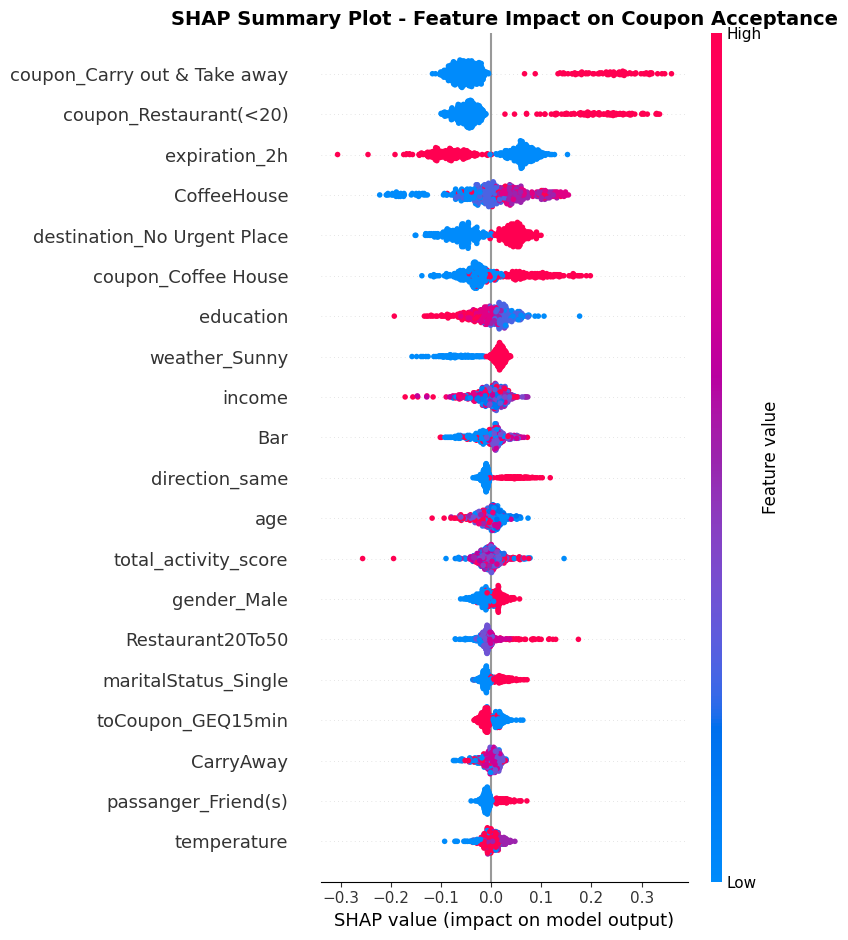

   Creating bar plot...


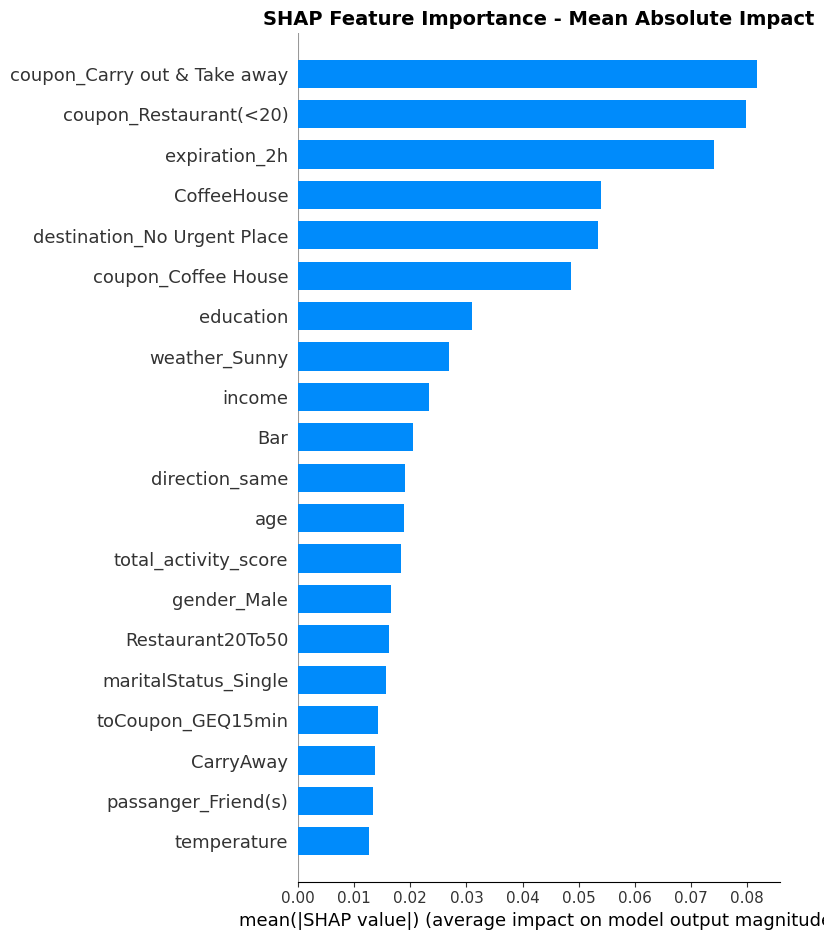

   Creating feature importance table...

📋 Top 15 Most Important Features:
    rank                       feature  mean_abs_shap  mean_shap  std_shap impact_direction
15     1  coupon_Carry out & Take away       0.081724  -0.007143  0.109947         Negative
18     2        coupon_Restaurant(<20)       0.079802   0.004170  0.107716         Positive
19     3                 expiration_2h       0.074099  -0.003110  0.080832         Negative
4      4                   CoffeeHouse       0.053863   0.005117  0.072490         Positive
8      5   destination_No Urgent Place       0.053413  -0.007785  0.058660         Negative
16     6           coupon_Coffee House       0.048605   0.003109  0.061442         Positive
1      7                     education       0.030993  -0.000909  0.040362         Negative
14     8                 weather_Sunny       0.026811   0.000522  0.036910         Positive
2      9                        income       0.023356  -0.001938  0.032103         Negative
3    

<Figure size 1000x600 with 0 Axes>

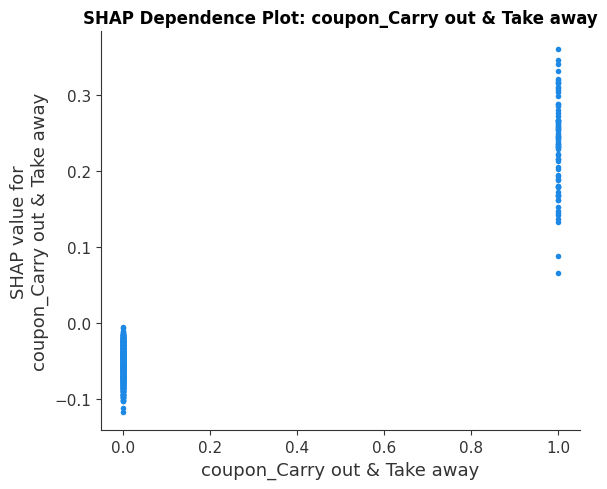

<Figure size 1000x600 with 0 Axes>

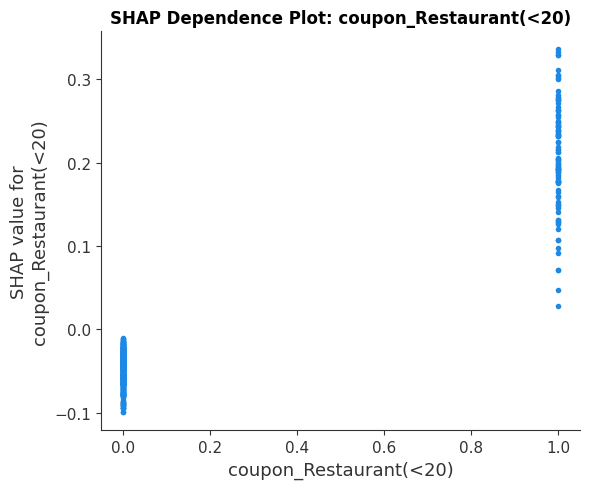

<Figure size 1000x600 with 0 Axes>

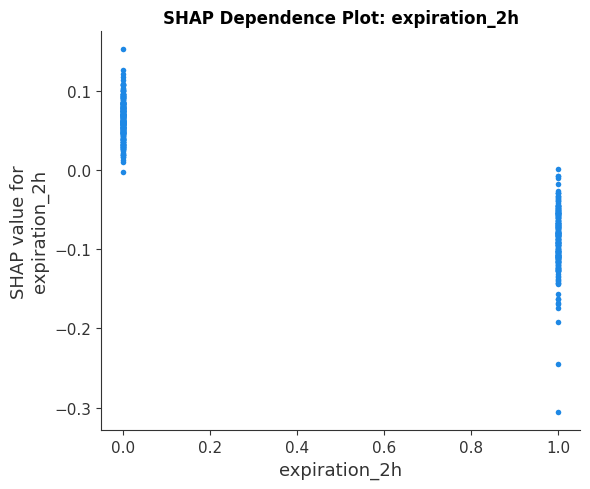

<Figure size 1000x600 with 0 Axes>

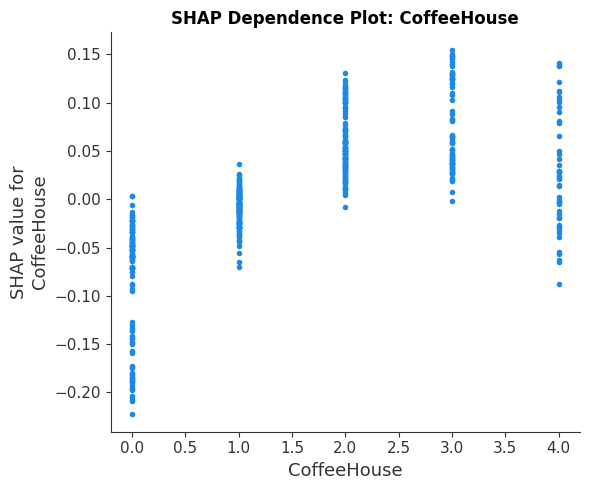

<Figure size 1000x600 with 0 Axes>

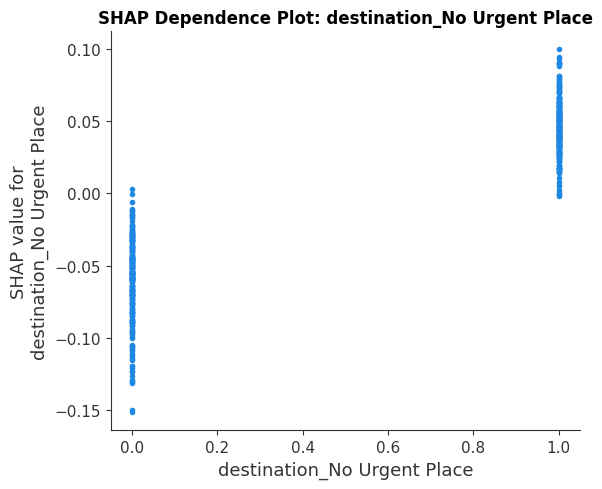


💧 Creating waterfall plots for representative instances...


TypeError: TreeEnsemble.predict() got an unexpected keyword argument 'raw_score'

In [220]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

def get_feature_names_from_column_transformer(column_transformer):
    """Extract feature names from ColumnTransformer"""
    feature_names = []
    
    for name, transformer, features in column_transformer.transformers_:
        if transformer == 'passthrough':
            feature_names.extend(features)
        elif hasattr(transformer, 'get_feature_names_out'):
            if name == 'cat':  # OneHotEncoder
                transformed_names = transformer.get_feature_names_out(features)
                feature_names.extend(transformed_names)
            else:
                feature_names.extend(features)
        else:
            feature_names.extend(features)
    
    return feature_names

def full_shap_analysis(model, preprocessor, X_raw, y_raw, X_processed=None, sample_size=1000):
    """
    Complete SHAP analysis for LightGBM model with preprocessing pipeline
    
    Parameters:
    - model: Trained LightGBM model
    - preprocessor: Fitted preprocessing transformer
    - X_raw: Raw features (before preprocessing)
    - y_raw: Target variable
    - X_processed: Preprocessed features (optional)
    - sample_size: Number of samples for SHAP analysis
    """
    
    print("=" * 60)
    print("STARTING COMPREHENSIVE SHAP ANALYSIS")
    print("=" * 60)
    
    # 1. Prepare the data
    if X_processed is None:
        X_processed = preprocessor.transform(X_raw)
    
    # Get feature names
    try:
        feature_names = get_feature_names_from_column_transformer(preprocessor)
        print(f"✓ Extracted {len(feature_names)} feature names from preprocessor")
    except Exception as e:
        print(f"⚠ Could not extract feature names: {e}")
        feature_names = [f"feature_{i}" for i in range(X_processed.shape[1])]
        print(f"Using generic feature names: {len(feature_names)} features")
    
    # Sample data for SHAP (for performance)
    if X_processed.shape[0] > sample_size:
        sample_indices = np.random.choice(X_processed.shape[0], sample_size, replace=False)
        X_shap = X_processed[sample_indices]
        X_raw_sample = X_raw.iloc[sample_indices]
    else:
        X_shap = X_processed
        X_raw_sample = X_raw
        sample_indices = np.arange(X_processed.shape[0])
    
    print(f"✓ Using {len(X_shap)} samples for SHAP analysis")
    
    # 2. Initialize SHAP Explainer
    print("\n🔍 Initializing SHAP TreeExplainer...")
    try:
        explainer = shap.TreeExplainer(
            model, 
            X_shap,  # background data
            model_output='probability'
        )
        print("✓ TreeExplainer initialized successfully")
    except Exception as e:
        print(f"❌ TreeExplainer failed: {e}")
        print("Trying alternative initialization...")
        explainer = shap.TreeExplainer(model)
        print("✓ TreeExplainer initialized without background data")
    
    # 3. Calculate SHAP values
    print("\n📊 Calculating SHAP values...")
    try:
        # For LightGBM with probability output
        shap_values = explainer.shap_values(X_shap)
        
        # Handle binary classification (LightGBM returns list for multi-class)
        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # Use class 1 (accept coupon)
            print("✓ Using SHAP values for class 1 (accept coupon)")
        else:
            print("✓ Using single SHAP values array")
            
        expected_value = explainer.expected_value
        if isinstance(expected_value, list):
            expected_value = expected_value[1]
            
        print(f"✓ SHAP values calculated: {shap_values.shape}")
        print(f"✓ Base (expected) value: {expected_value:.4f}")
        
    except Exception as e:
        print(f"❌ SHAP values calculation failed: {e}")
        return None
    
    # Store results
    shap_results = {
        'explainer': explainer,
        'shap_values': shap_values,
        'X_shap': X_shap,
        'X_raw_sample': X_raw_sample,
        'feature_names': feature_names,
        'expected_value': expected_value,
        'sample_indices': sample_indices
    }
    
    # 4. Create comprehensive visualizations
    print("\n📈 Creating SHAP visualizations...")
    
    # 4.1 Summary Plot (Bee Swarm)
    print("   Creating summary plot...")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values, 
        X_shap,
        feature_names=feature_names,
        max_display=20,
        show=False
    )
    plt.title("SHAP Summary Plot - Feature Impact on Coupon Acceptance", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 4.2 Bar Plot (Mean |SHAP|)
    print("   Creating bar plot...")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values, 
        X_shap,
        feature_names=feature_names,
        plot_type="bar",
        max_display=20,
        show=False
    )
    plt.title("SHAP Feature Importance - Mean Absolute Impact", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 4.3 Custom Feature Importance DataFrame
    print("   Creating feature importance table...")
    importance_df = create_feature_importance_df(shap_values, feature_names)
    print("\n📋 Top 15 Most Important Features:")
    print(importance_df.head(15).to_string())
    
    # 4.4 Dependence Plots for Top Features
    print("\n🔬 Creating dependence plots for top features...")
    top_features = importance_df.head(5)['feature'].tolist()
    for i, feature in enumerate(top_features):
        if feature in feature_names:
            feature_idx = feature_names.index(feature)
            plt.figure(figsize=(10, 6))
            shap.dependence_plot(
                feature_idx,
                shap_values,
                X_shap,
                feature_names=feature_names,
                interaction_index=None,
                show=False
            )
            plt.title(f"SHAP Dependence Plot: {feature}", fontsize=12, fontweight='bold')
            plt.tight_layout()
            plt.show()
    
    # 4.5 Waterfall plots for specific instances
    print("\n💧 Creating waterfall plots for representative instances...")
    create_representative_waterfalls(shap_results, n_instances=3)
    
    # 4.6 Force plot for first few instances
    print("\n🎯 Creating force plots...")
    create_force_plots(shap_results, n_instances=3)
    
    # 4.7 Feature clustering (if enough features)
    if len(feature_names) > 10:
        print("\n🔗 Creating feature clustering...")
        try:
            plt.figure(figsize=(12, 10))
            shap.plots.clustering(shap_values, X_shap, feature_names=feature_names, show=False)
            plt.title("SHAP Feature Clustering", fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"   Clustering not available: {e}")
    
    print("\n" + "=" * 60)
    print("SHAP ANALYSIS COMPLETE!")
    print("=" * 60)
    
    return shap_results

def create_feature_importance_df(shap_values, feature_names):
    """Create a DataFrame with feature importance metrics"""
    importance_data = []
    
    for i, feature in enumerate(feature_names):
        abs_shap = np.abs(shap_values[:, i])
        mean_abs_shap = np.mean(abs_shap)
        std_shap = np.std(shap_values[:, i])
        mean_shap = np.mean(shap_values[:, i])
        
        importance_data.append({
            'feature': feature,
            'mean_abs_shap': mean_abs_shap,
            'mean_shap': mean_shap,
            'std_shap': std_shap,
            'impact_direction': 'Positive' if mean_shap > 0 else 'Negative'
        })
    
    importance_df = pd.DataFrame(importance_data)
    importance_df = importance_df.sort_values('mean_abs_shap', ascending=False)
    importance_df['rank'] = range(1, len(importance_df) + 1)
    
    return importance_df[['rank', 'feature', 'mean_abs_shap', 'mean_shap', 'std_shap', 'impact_direction']]

def create_representative_waterfalls(shap_results, n_instances=3):
    """Create waterfall plots for representative instances"""
    shap_values = shap_results['shap_values']
    expected_value = shap_results['expected_value']
    feature_names = shap_results['feature_names']
    X_shap = shap_results['X_shap']
    
    # Find instances with different prediction probabilities
    model = shap_results['explainer'].model
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(X_shap)[:, 1]
    else:
        probabilities = model.predict(X_shap, raw_score=True)
        probabilities = 1 / (1 + np.exp(-probabilities))  # sigmoid
    
    # Select diverse instances
    quantiles = np.linspace(0.1, 0.9, n_instances)
    selected_indices = []
    
    for q in quantiles:
        idx = np.argsort(np.abs(probabilities - q))[0]
        selected_indices.append(idx)
    
    for i, idx in enumerate(selected_indices):
        plt.figure(figsize=(12, 8))
        shap.waterfall_plot(
            shap.Explanation(
                values=shap_values[idx],
                base_values=expected_value,
                data=X_shap[idx],
                feature_names=feature_names
            ),
            max_display=15,
            show=False
        )
        plt.title(f"Waterfall Plot - Instance {i+1} (Prob: {probabilities[idx]:.3f})", 
                 fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()

def create_force_plots(shap_results, n_instances=3):
    """Create force plots for individual predictions"""
    shap_values = shap_results['shap_values']
    expected_value = shap_results['expected_value']
    feature_names = shap_results['feature_names']
    X_shap = shap_results['X_shap']
    
    for i in range(min(n_instances, len(X_shap))):
        print(f"\nForce plot for instance {i+1}:")
        shap.force_plot(
            expected_value,
            shap_values[i],
            X_shap[i],
            feature_names=feature_names,
            matplotlib=True,
            show=False,
            text_rotation=45
        )
        plt.tight_layout()
        plt.show()

def interpret_shap_results(shap_results, top_n=10):
    """Provide business interpretation of SHAP results"""
    importance_df = create_feature_importance_df(shap_results['shap_values'], shap_results['feature_names'])
    top_features = importance_df.head(top_n)
    
    print("\n" + "=" * 60)
    print("BUSINESS INTERPRETATION")
    print("=" * 60)
    
    print(f"\n🔑 Top {top_n} Drivers of Coupon Acceptance:")
    print("-" * 50)
    
    for _, row in top_features.iterrows():
        feature = row['feature']
        impact = row['mean_shap']
        magnitude = row['mean_abs_shap']
        direction = "increases" if impact > 0 else "decreases"
        
        print(f"\n📍 {feature}")
        print(f"   • Impact: {abs(impact):.4f} ({direction} acceptance)")
        print(f"   • Magnitude: {magnitude:.4f}")
        
        # Provide business context for common features
        if 'coupon' in feature.lower():
            print(f"   • Business: Coupon type strongly influences acceptance")
        elif 'time' in feature.lower() or 'expiration' in feature.lower():
            print(f"   • Business: Time sensitivity affects decision making")
        elif 'weather' in feature.lower():
            print(f"   • Business: Weather conditions impact coupon utility")
        elif 'occupation' in feature.lower():
            print(f"   • Business: Occupation correlates with lifestyle needs")
    
    # Overall insights
    positive_impact = len([x for x in top_features['mean_shap'] if x > 0])
    negative_impact = len([x for x in top_features['mean_shap'] if x < 0])
    
    print(f"\n📊 Summary:")
    print(f"   • {positive_impact} features increase acceptance probability")
    print(f"   • {negative_impact} features decrease acceptance probability")
    print(f"   • Top feature explains {top_features.iloc[0]['mean_abs_shap']:.3f} in probability units")

# =============================================================================
# EXECUTE THE COMPLETE ANALYSIS
# =============================================================================

# Your existing code
print("Loading and preparing data...")
X = coupon_df.drop(columns=['accept_coupon'])
y = coupon_df['accept_coupon']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply preprocessing pipeline
print("Applying preprocessing pipeline...")
modes = fit_data_cleaner(X_train)
X_train_clean = transform_data_cleaner(X_train, modes)
X_test_clean = transform_data_cleaner(X_test, modes)

fe = FeatureEngineer()
fe.fit(X_train_clean)
X_train_eng = fe.transform(X_train_clean)
X_test_eng = fe.transform(X_test_clean)

preprocessing_transformer.fit(X_train_eng)
X_train_processed = preprocessing_transformer.transform(X_train_eng)
X_test_processed = preprocessing_transformer.transform(X_test_eng)

# Train model
print("Training LightGBM model...")
final_xgb = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
final_xgb.fit(X_train_processed, y_train)

# Evaluate
print("Evaluating model...")
y_pred_proba = final_xgb.predict_proba(X_test_processed)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"✅ Final Test AUC: {test_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_xgb.predict(X_test_processed)))

# Run comprehensive SHAP analysis
print("\n" + "=" * 60)
print("STARTING SHAP ANALYSIS")
print("=" * 60)

shap_results = full_shap_analysis(
    model=final_xgb,
    preprocessor=preprocessing_transformer,
    X_raw=X_test_eng,  # Use test data for explanation
    y_raw=y_test,
    X_processed=X_test_processed,
    sample_size=500  # Adjust based on your data size
)

if shap_results is not None:
    # Provide business interpretation
    interpret_shap_results(shap_results, top_n=15)
    
    # Save results for later use
    print("\n💾 Saving SHAP results...")
    importance_df = create_feature_importance_df(shap_results['shap_values'], shap_results['feature_names'])
    importance_df.to_csv('shap_feature_importance.csv', index=False)
    print("✅ SHAP analysis complete and results saved!")
else:
    print("❌ SHAP analysis failed. Check the error messages above.")

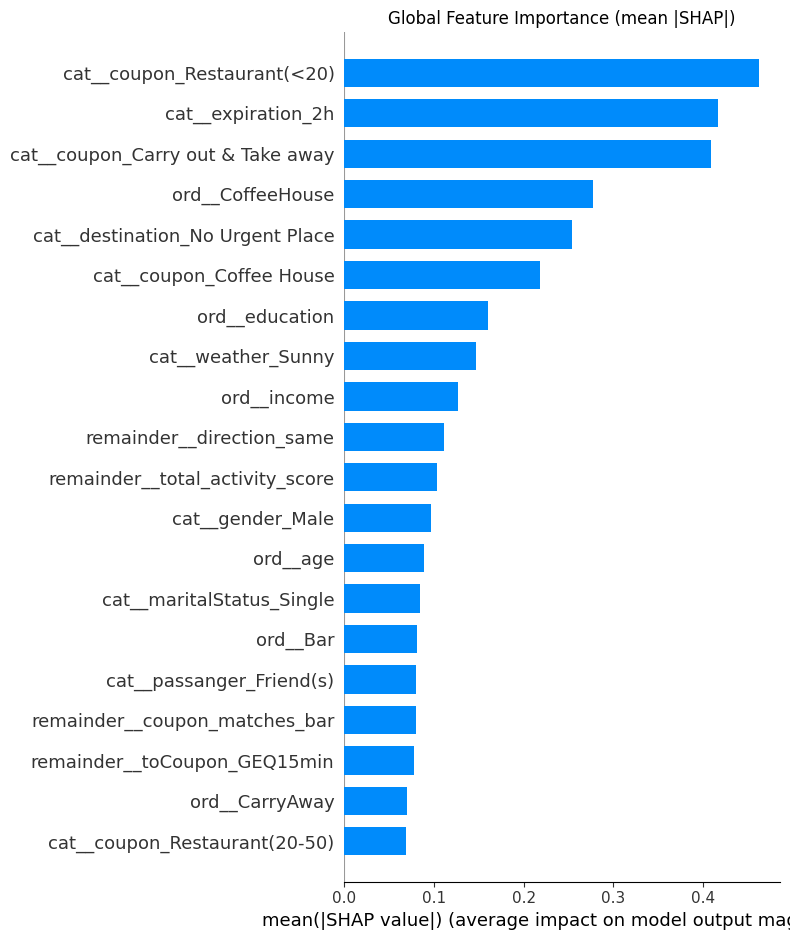

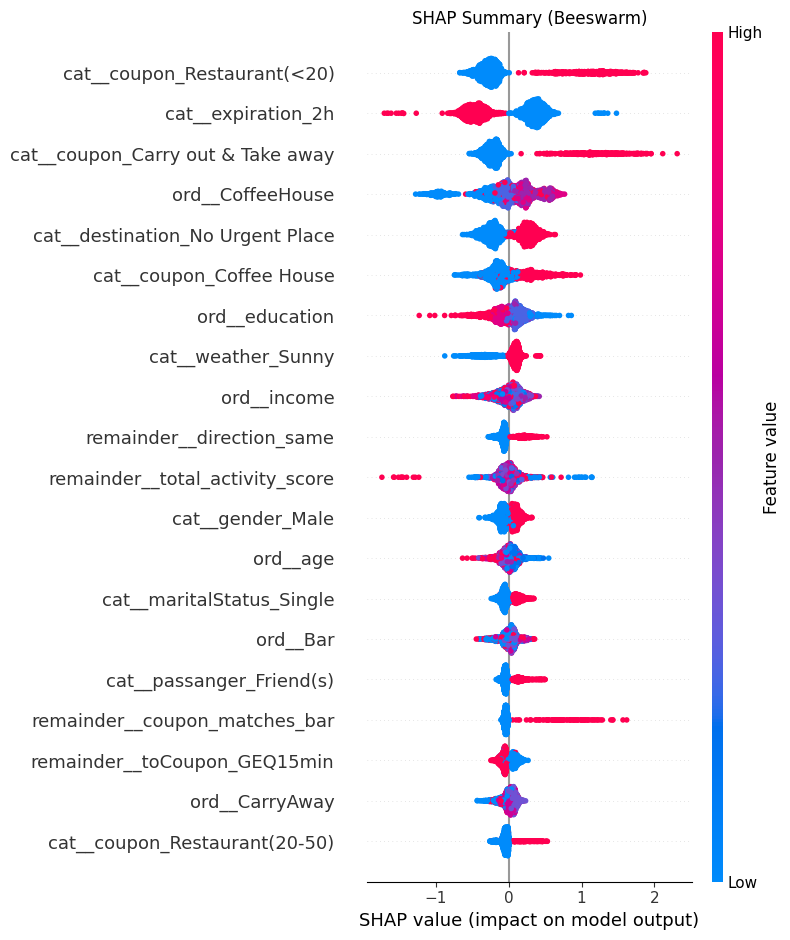

<Figure size 640x480 with 0 Axes>

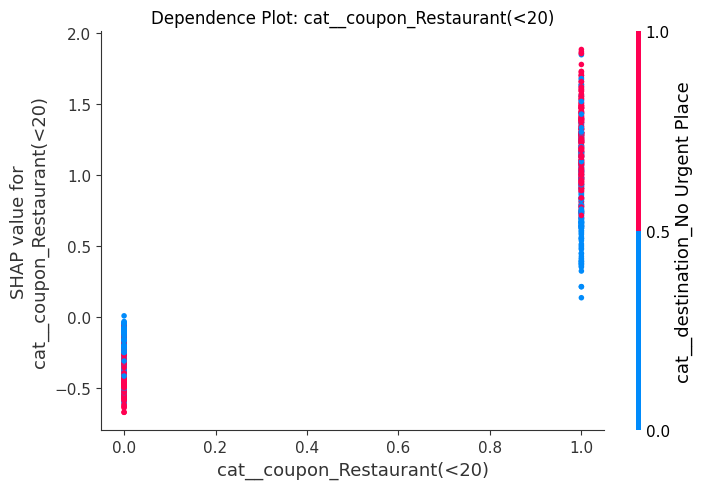

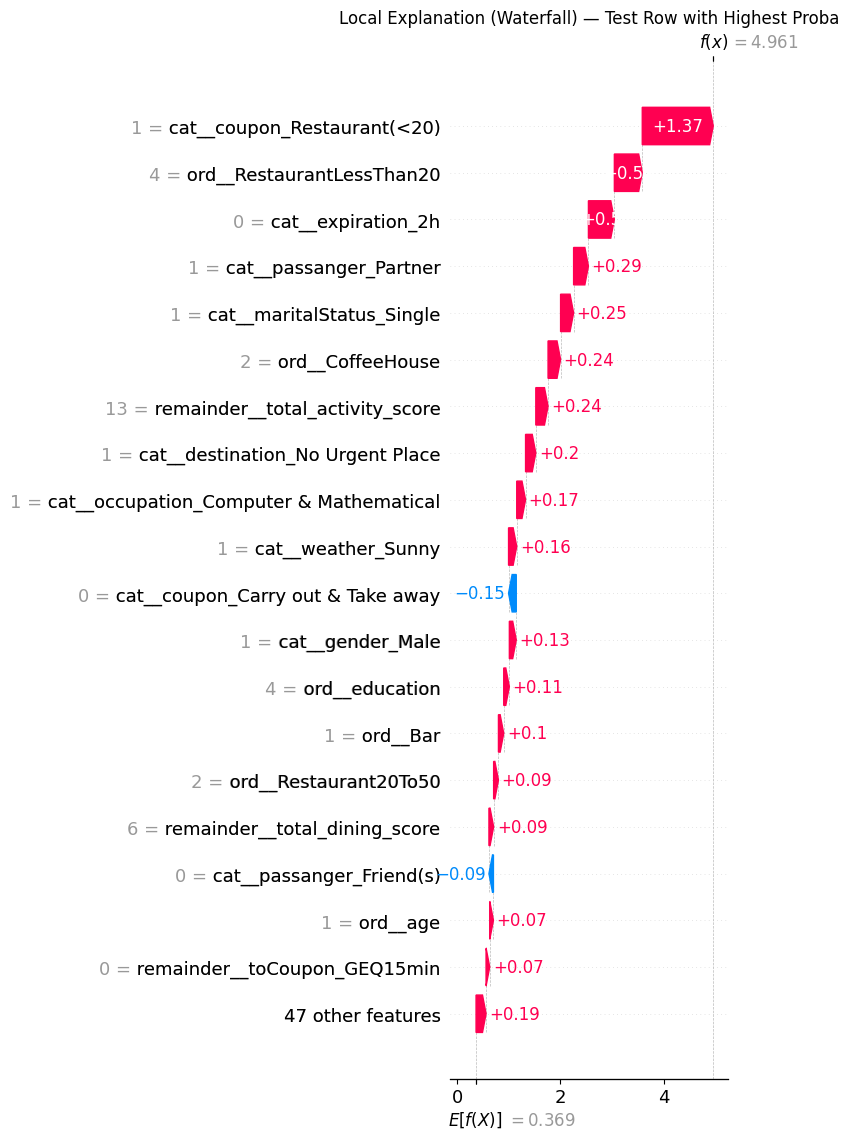


Top 15 features for high-proba cohort:
cat__coupon_Restaurant(<20)  (mean|SHAP|=0.891419)
cat__expiration_2h  (mean|SHAP|=0.519790)
cat__coupon_Carry out & Take away  (mean|SHAP|=0.485389)
cat__destination_No Urgent Place  (mean|SHAP|=0.246404)
ord__CoffeeHouse  (mean|SHAP|=0.195611)
ord__education  (mean|SHAP|=0.192213)
ord__RestaurantLessThan20  (mean|SHAP|=0.171361)
cat__passanger_Friend(s)  (mean|SHAP|=0.156698)
cat__coupon_Coffee House  (mean|SHAP|=0.149474)
ord__income  (mean|SHAP|=0.147938)
cat__weather_Sunny  (mean|SHAP|=0.139265)
cat__maritalStatus_Single  (mean|SHAP|=0.137429)
remainder__total_activity_score  (mean|SHAP|=0.127006)
ord__age  (mean|SHAP|=0.108231)
cat__gender_Male  (mean|SHAP|=0.097692)


In [221]:
# ===== SHAP for your LightGBM model =====
import numpy as np
import scipy.sparse as sp
import shap
import matplotlib.pyplot as plt

# 0) Get final feature names from your fitted preprocessor
feature_names = None
try:
    feature_names = preprocessing_transformer.get_feature_names_out()
except Exception:
    # fallback if your transformer doesn't implement get_feature_names_out()
    feature_names = [f"f{i}" for i in range(X_train_processed.shape[1])]

# 1) Build a TreeExplainer for LightGBM
explainer = shap.TreeExplainer(final_xgb)  # LightGBM -> TreeExplainer is optimal

# 2) Compute SHAP values on test set
#    (use check_additivity=False to avoid additivity warnings with some LGBM settings)
shap_values = explainer.shap_values(X_test_processed, check_additivity=False)

# 3) Handle binary-vs-multiclass output shape
#    - For binary classifiers, SHAP (LightGBM API) often returns a list of 2 arrays [for class0, class1]
#    - We want the positive class (index 1) if it's a list; otherwise use the array directly
if isinstance(shap_values, list):
    shap_vals_pos = shap_values[1]
    expected_value = explainer.expected_value[1]
else:
    shap_vals_pos = shap_values
    expected_value = explainer.expected_value

# 4) Convert sparse -> dense ONLY for plotting utilities that need dense matrices
def to_dense(m):
    return m.toarray() if sp.issparse(m) else np.asarray(m)

X_test_dense = to_dense(X_test_processed)

# 5) Optional: Subsample for faster plots if test is large
max_points = 2000
if X_test_dense.shape[0] > max_points:
    rng = np.random.default_rng(42)
    idx = rng.choice(X_test_dense.shape[0], size=max_points, replace=False)
    X_plot = X_test_dense[idx]
    shap_plot = shap_vals_pos[idx]
else:
    X_plot = X_test_dense
    shap_plot = shap_vals_pos

# ============================================================
# SIMPLE / GLOBAL VIEW
# ============================================================

# 5a) Global importance (mean |SHAP|) — bar chart
plt.figure()
shap.summary_plot(shap_plot, X_plot, feature_names=feature_names, plot_type="bar", show=False)
plt.title("Global Feature Importance (mean |SHAP|)")
plt.tight_layout()
plt.show()

# 5b) Beewswarm summary — shows direction & magnitude
plt.figure()
shap.summary_plot(shap_plot, X_plot, feature_names=feature_names, show=False)
plt.title("SHAP Summary (Beeswarm)")
plt.tight_layout()
plt.show()

# 5c) Dependence plot for the top feature (auto-picked)
#     (You can pick another feature by name/index)
top_feature_index = int(np.argsort(np.mean(np.abs(shap_plot), axis=0))[-1])
plt.figure()
shap.dependence_plot(
    ind=top_feature_index,
    shap_values=shap_plot,
    features=X_plot,
    feature_names=feature_names,
    show=False
)
plt.title(f"Dependence Plot: {feature_names[top_feature_index]}")
plt.tight_layout()
plt.show()

# ============================================================
# DEEP / LOCAL DIVE
# ============================================================

# 6) Explain one prediction in detail (waterfall + force)
#    Pick a representative row from test set, e.g., highest predicted prob
y_proba_test = final_xgb.predict_proba(X_test_processed)[:, 1]
row_ix = int(np.argmax(y_proba_test))  # or choose any index you like

# Build a SHAP Explanation object for the chosen row (required by newer waterfall/force plots)
base = expected_value
values_row = shap_vals_pos[row_ix]
data_row = X_test_dense[row_ix]
expl_row = shap.Explanation(
    values=values_row,
    base_values=base,
    data=data_row,
    feature_names=feature_names
)

# 6a) Waterfall plot (how each feature moves the prediction from the base value)
plt.figure()
shap.plots.waterfall(expl_row, show=False, max_display=20)
plt.title("Local Explanation (Waterfall) — Test Row with Highest Proba")
plt.tight_layout()
plt.show()

# 6b) Force plot for the same row (JS viewer in notebooks)
#     If in a notebook, you can init JS for inline viz:
# shap.initjs()
shap.plots.force(expl_row)  # in many IDEs, renders inline; else use shap.save_html(...)
# To save as HTML:
# shap.save_html("force_row.html", shap.plots.force(expl_row))

# ============================================================
# OPTIONAL: Cohort (slice) explanations
# ============================================================
# Example: top 100 highest proba rows — average their SHAP for a cohort view
k = 100 if X_test_dense.shape[0] >= 100 else X_test_dense.shape[0]
top_idx = np.argsort(y_proba_test)[-k:]
cohort_mean_abs = np.mean(np.abs(shap_vals_pos[top_idx]), axis=0)
topk_feat_idx = np.argsort(cohort_mean_abs)[-15:][::-1]
print("\nTop 15 features for high-proba cohort:")
for i in topk_feat_idx:
    print(f"{feature_names[i]}  (mean|SHAP|={cohort_mean_abs[i]:.6f})")
